# Multi-session analysis
This notebook demonstrate how to combine different xarray dataset together and perform group-level analysis

In [1]:
%reload_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pylab as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import numpy as np
from glob import glob
import re
from datetime import datetime
from trialexp.process.folder_org.utils import build_session_info, load_and_concat_dataset, filter_sessions, load_pycontrol_variables
from trialexp.process.group_analysis.plot_utils import plot_group_average, plot_subject_average, plot_subject_comparison
import itertools

## Build dataframe containing the metadata of all sessions

`build_session_info` will extract information from the by_sessions folder and build a dataframe for further filtering


In [2]:
#specify the location of the by_sessions folder here
root_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions'

df_session_info = build_session_info(root_path, load_pycontrol=True, pycontrol_parameters=['hold_time_required_ms', 'US_delay_ms'], param_extract_method='tail')
df_session_info['hold_time_required_ms']=df_session_info['hold_time_required_ms'].astype(float)
df_session_info['US_delay_ms'] = df_session_info['US_delay_ms'].astype(float)
df_session_info

animal_id       expt_datetime                session_id  \
0      JC316L 2022-12-11 20:26:00  JC316L-2022-12-11-202600   
1      JC317L 2022-12-09 17:19:26  JC317L-2022-12-09-171926   
2      JC317L 2022-12-11 20:26:00  JC317L-2022-12-11-202600   
3      JC316L 2022-12-09 17:19:25  JC316L-2022-12-09-171925   
4      JC317L 2022-12-16 17:31:45  JC317L-2022-12-16-173145   
..        ...                 ...                       ...   
839    kms049 2022-08-22 11:07:10  kms049-2022-08-22-110710   
840    kms053 2022-09-27 14:12:56  kms053-2022-09-27-141256   
841    kms047 2022-09-21 11:22:12  kms047-2022-09-21-112212   
842    kms051 2022-08-25 16:15:18  kms051-2022-08-25-161518   
843    kms048 2022-09-26 11:13:57  kms048-2022-09-26-111357   

                                       task_name  \
0    reaching_go_spout_bar_dual_all_reward_dec22   
1    reaching_go_spout_bar_dual_all_reward_dec22   
2    reaching_go_spout_bar_dual_all_reward_dec22   
3    reaching_go_spout_bar_dual_all_reward_dec22   
4         reaching_go_spout_bar_all_reward_dec22   
..                                           ...   
839                reaching_go_spout_cued_uncued   
840                reaching_go_spout_cued_uncued   
841                reaching_go_spout_cued_uncued   
842                reaching_go_spout_cued_uncued   
843                reaching_go_spout_cued_uncued   

                                                  path  session_no  \
0    /home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...         2.0   
1    /home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...         1.0   
2    /home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...         2.0   
3    /home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...         1.0   
4    /home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...         1.0   
..                                                 ...         ...   
839  /home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...         3.0   
840  /home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...        11.0   
841  /home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...        11.0   
842  /home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...         6.0   
843  /home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...        11.0   

     hold_time_required_ms  US_delay_ms  
0                      NaN          NaN  
1                      NaN          NaN  
2                      NaN          NaN  
3                      NaN          NaN  
4                      NaN          NaN  
..                     ...          ...  
839                    NaN          NaN  
840                    NaN          NaN  
841                    NaN          NaN  
842                    NaN          NaN  
843                    NaN          NaN  

[844 rows x 8 columns]

## Filter data based on a pre-definied list

In [3]:
good_session_list = pd.read_csv('good_session_DA.txt')
df_sel = df_session_info[df_session_info.session_id.isin(good_session_list.session_id)]
df_sel.sort_values(['animal_id','expt_datetime'])
df_sel.to_pickle('DA_sessions.pkl')

In [29]:
paths = df_sel.path
ds_combined = load_and_concat_dataset(paths)

  0%|          | 0/31 [00:00<?, ?it/s]

/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms063-2023-04-01-180930/processed/xr_session.nc not found! skipping
/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms062-2023-02-23-143355/processed/xr_session.nc not found! skipping
/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms064-2023-02-14-115018/processed/xr_session.nc not found! skipping
Concating datasets...


In [30]:
ds_combined

<xarray.Dataset>
Dimensions:                           (trial_nb: 324, event_time: 500,
                                       session_id: 28)
Coordinates:
  * trial_nb                          (trial_nb) int64 1 2 3 4 ... 322 323 324
  * event_time                        (event_time) int64 -1995 -1985 ... 2995
  * session_id                        (session_id) object 'JC317L-2022-12-09-...
Data variables: (12/23)
    uid                               (session_id, trial_nb) object 'JC317L_2...
    trigger                           (session_id, trial_nb) object 'hold_for...
    valid                             (session_id, trial_nb) float64 1.0 ... nan
    Go_to_get_water                   (session_id, trial_nb) float64 1.0 ... nan
    US_end_timer                      (session_id, trial_nb) float64 0.0 ... nan
    break_after_abort                 (session_id, trial_nb) float64 0.0 ... nan
    ...                                ...
    trial_outcome                     (session_id, trial_nb) object 'no_reach...
    hold_for_water_zscored_df_over_f  (session_id, trial_nb, event_time) float64 ...
    first_bar_off_zscored_df_over_f   (session_id, trial_nb, event_time) float64 ...
    first_spout_zscored_df_over_f     (session_id, trial_nb, event_time) float64 ...
    last_bar_off_zscored_df_over_f    (session_id, trial_nb, event_time) float64 ...
    waiting_for_spout                 (session_id, trial_nb) float64 nan ... nan

## Plot figures

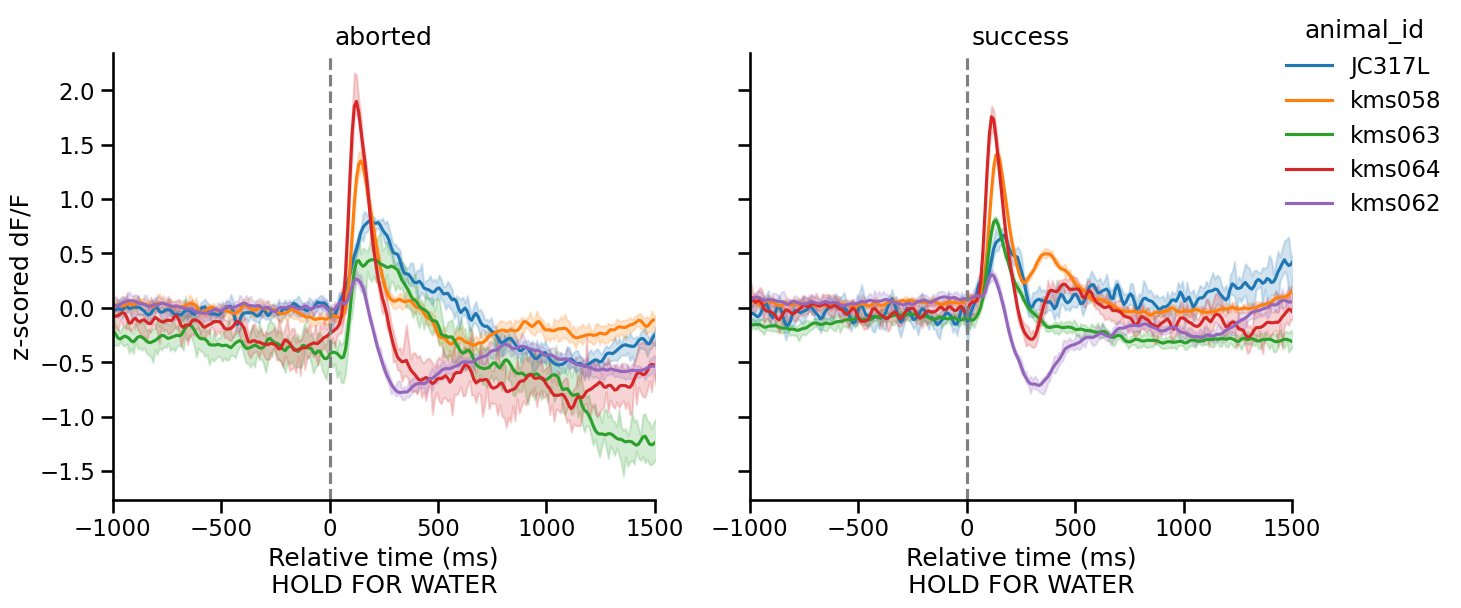

In [31]:
sns.set_context('talk',font_scale=1)

animal_id = df_sel[['animal_id','session_id','expt_datetime']]

fig = plot_subject_average(ds_combined, animal_id, 'hold_for_water_zscored_df_over_f', n_boot=10);


## Plot and save

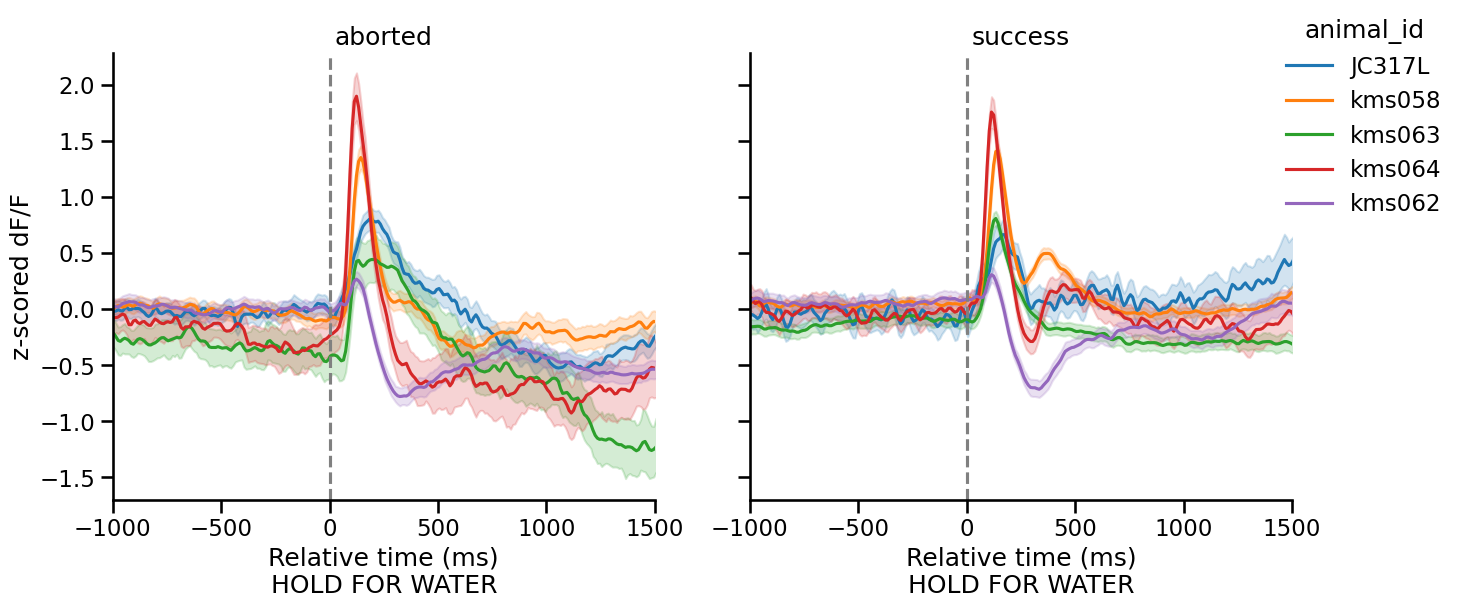

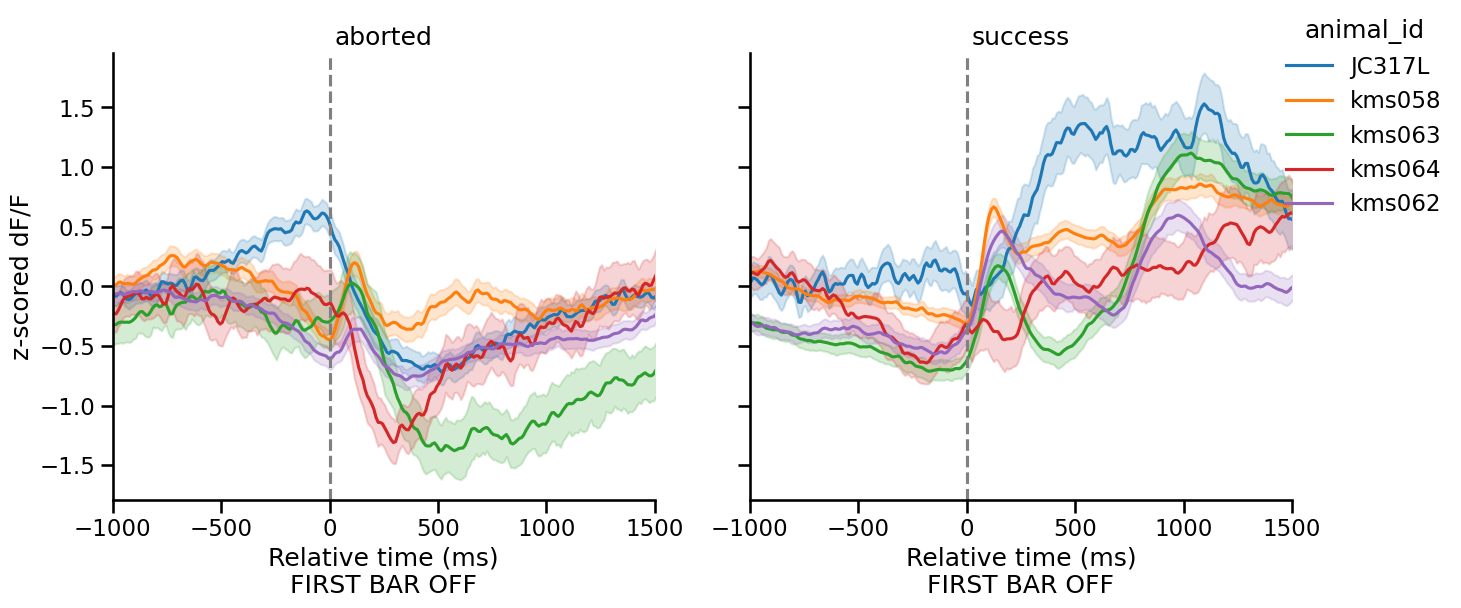

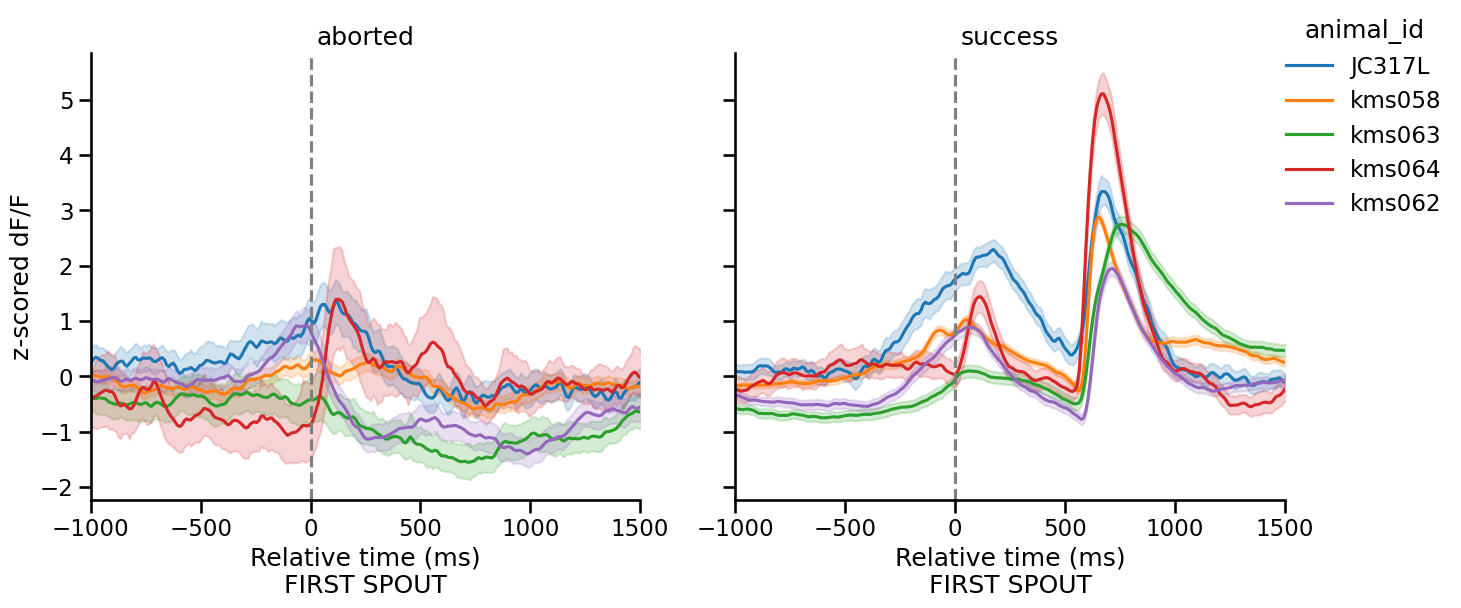

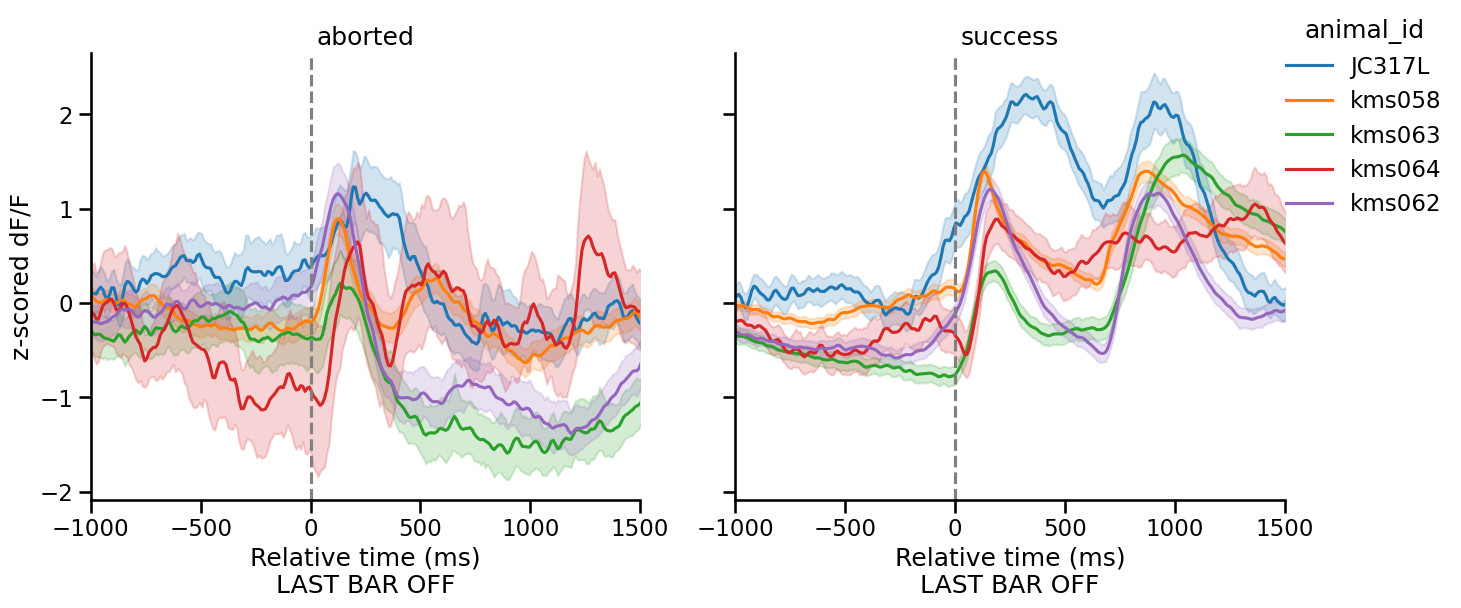

In [32]:
vars_to_plot = ['hold_for_water_zscored_df_over_f', 
                'first_bar_off_zscored_df_over_f',
                'first_spout_zscored_df_over_f',
                'last_bar_off_zscored_df_over_f']

for v in vars_to_plot:
    fig= plot_subject_average(ds_combined, animal_id, v)
    fig.savefig(f'figures/DA_subject_average_{v}.png', bbox_inches='tight', dpi=300)

Using 251 trials for each subjects


/home/MRC.OX.AC.UK/ndcn1330/code/trialexp/trialexp/process/group_analysis/plot_utils.py:115: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2plot = df2plot.groupby(['animal_id','event_time','trial_outcome']).mean().reset_index()


Using 251 trials for each subjects


/home/MRC.OX.AC.UK/ndcn1330/code/trialexp/trialexp/process/group_analysis/plot_utils.py:115: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2plot = df2plot.groupby(['animal_id','event_time','trial_outcome']).mean().reset_index()


Using 187 trials for each subjects


/home/MRC.OX.AC.UK/ndcn1330/code/trialexp/trialexp/process/group_analysis/plot_utils.py:115: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2plot = df2plot.groupby(['animal_id','event_time','trial_outcome']).mean().reset_index()


Using 183 trials for each subjects


/home/MRC.OX.AC.UK/ndcn1330/code/trialexp/trialexp/process/group_analysis/plot_utils.py:115: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2plot = df2plot.groupby(['animal_id','event_time','trial_outcome']).mean().reset_index()


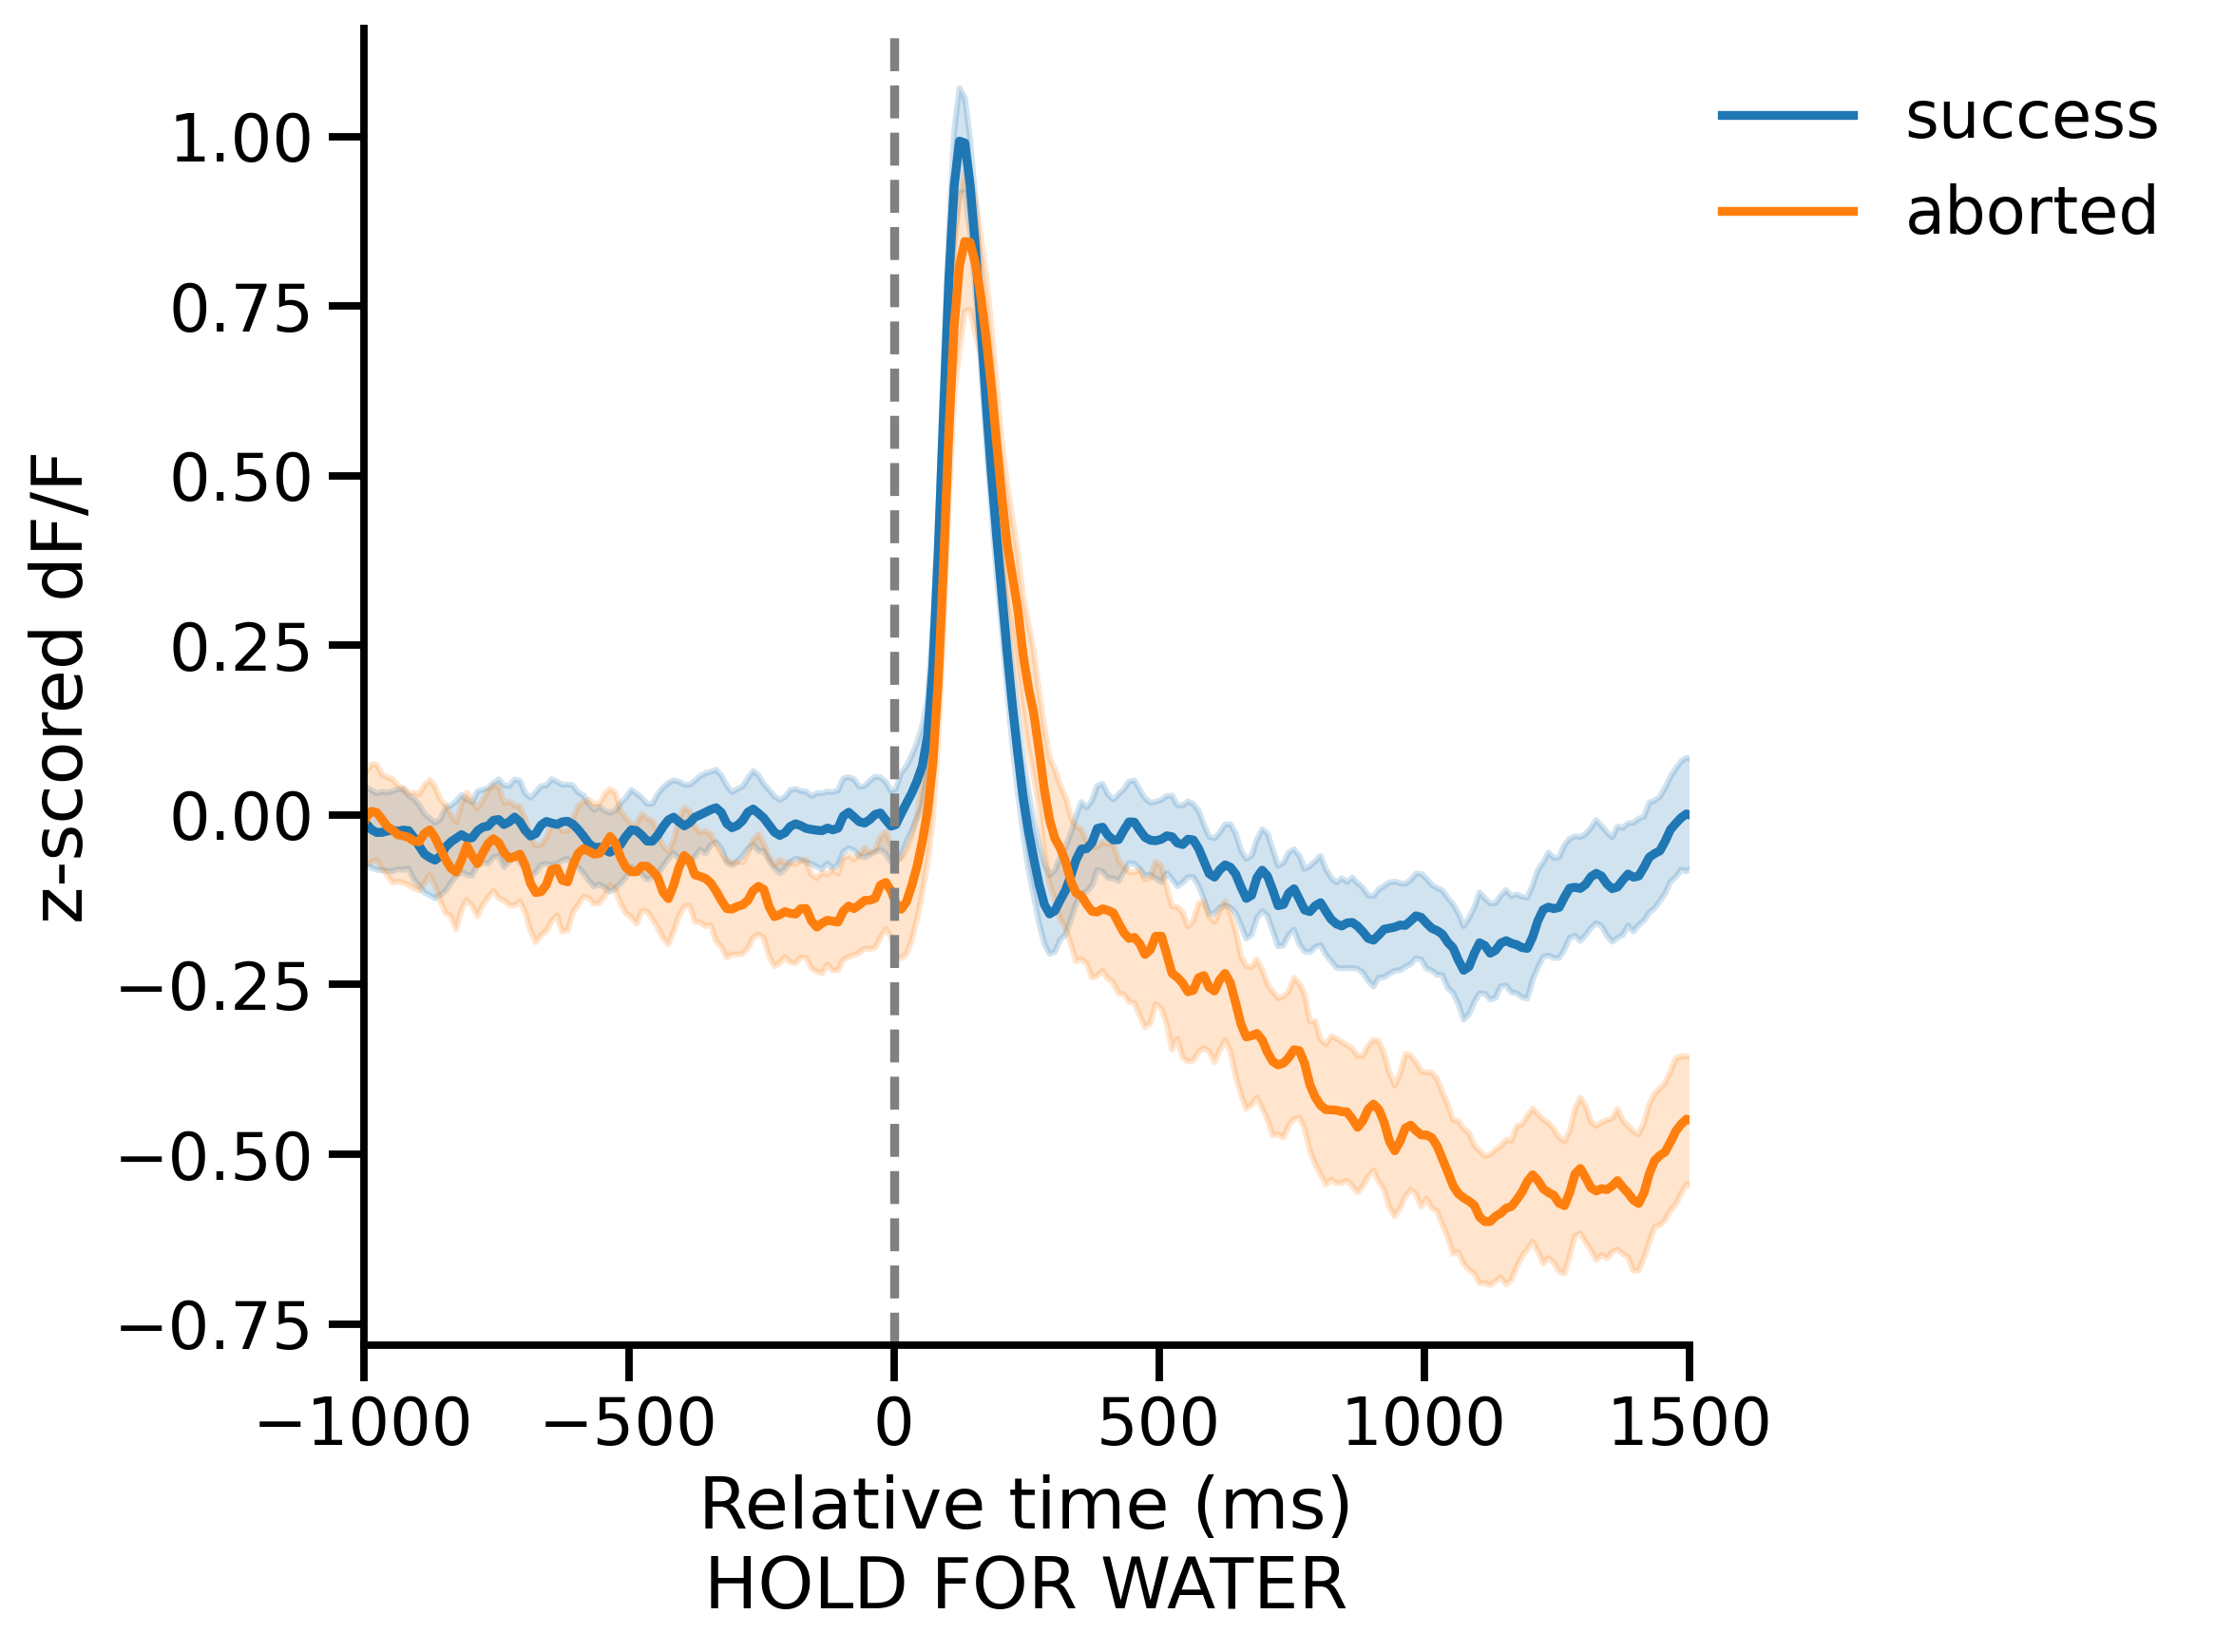

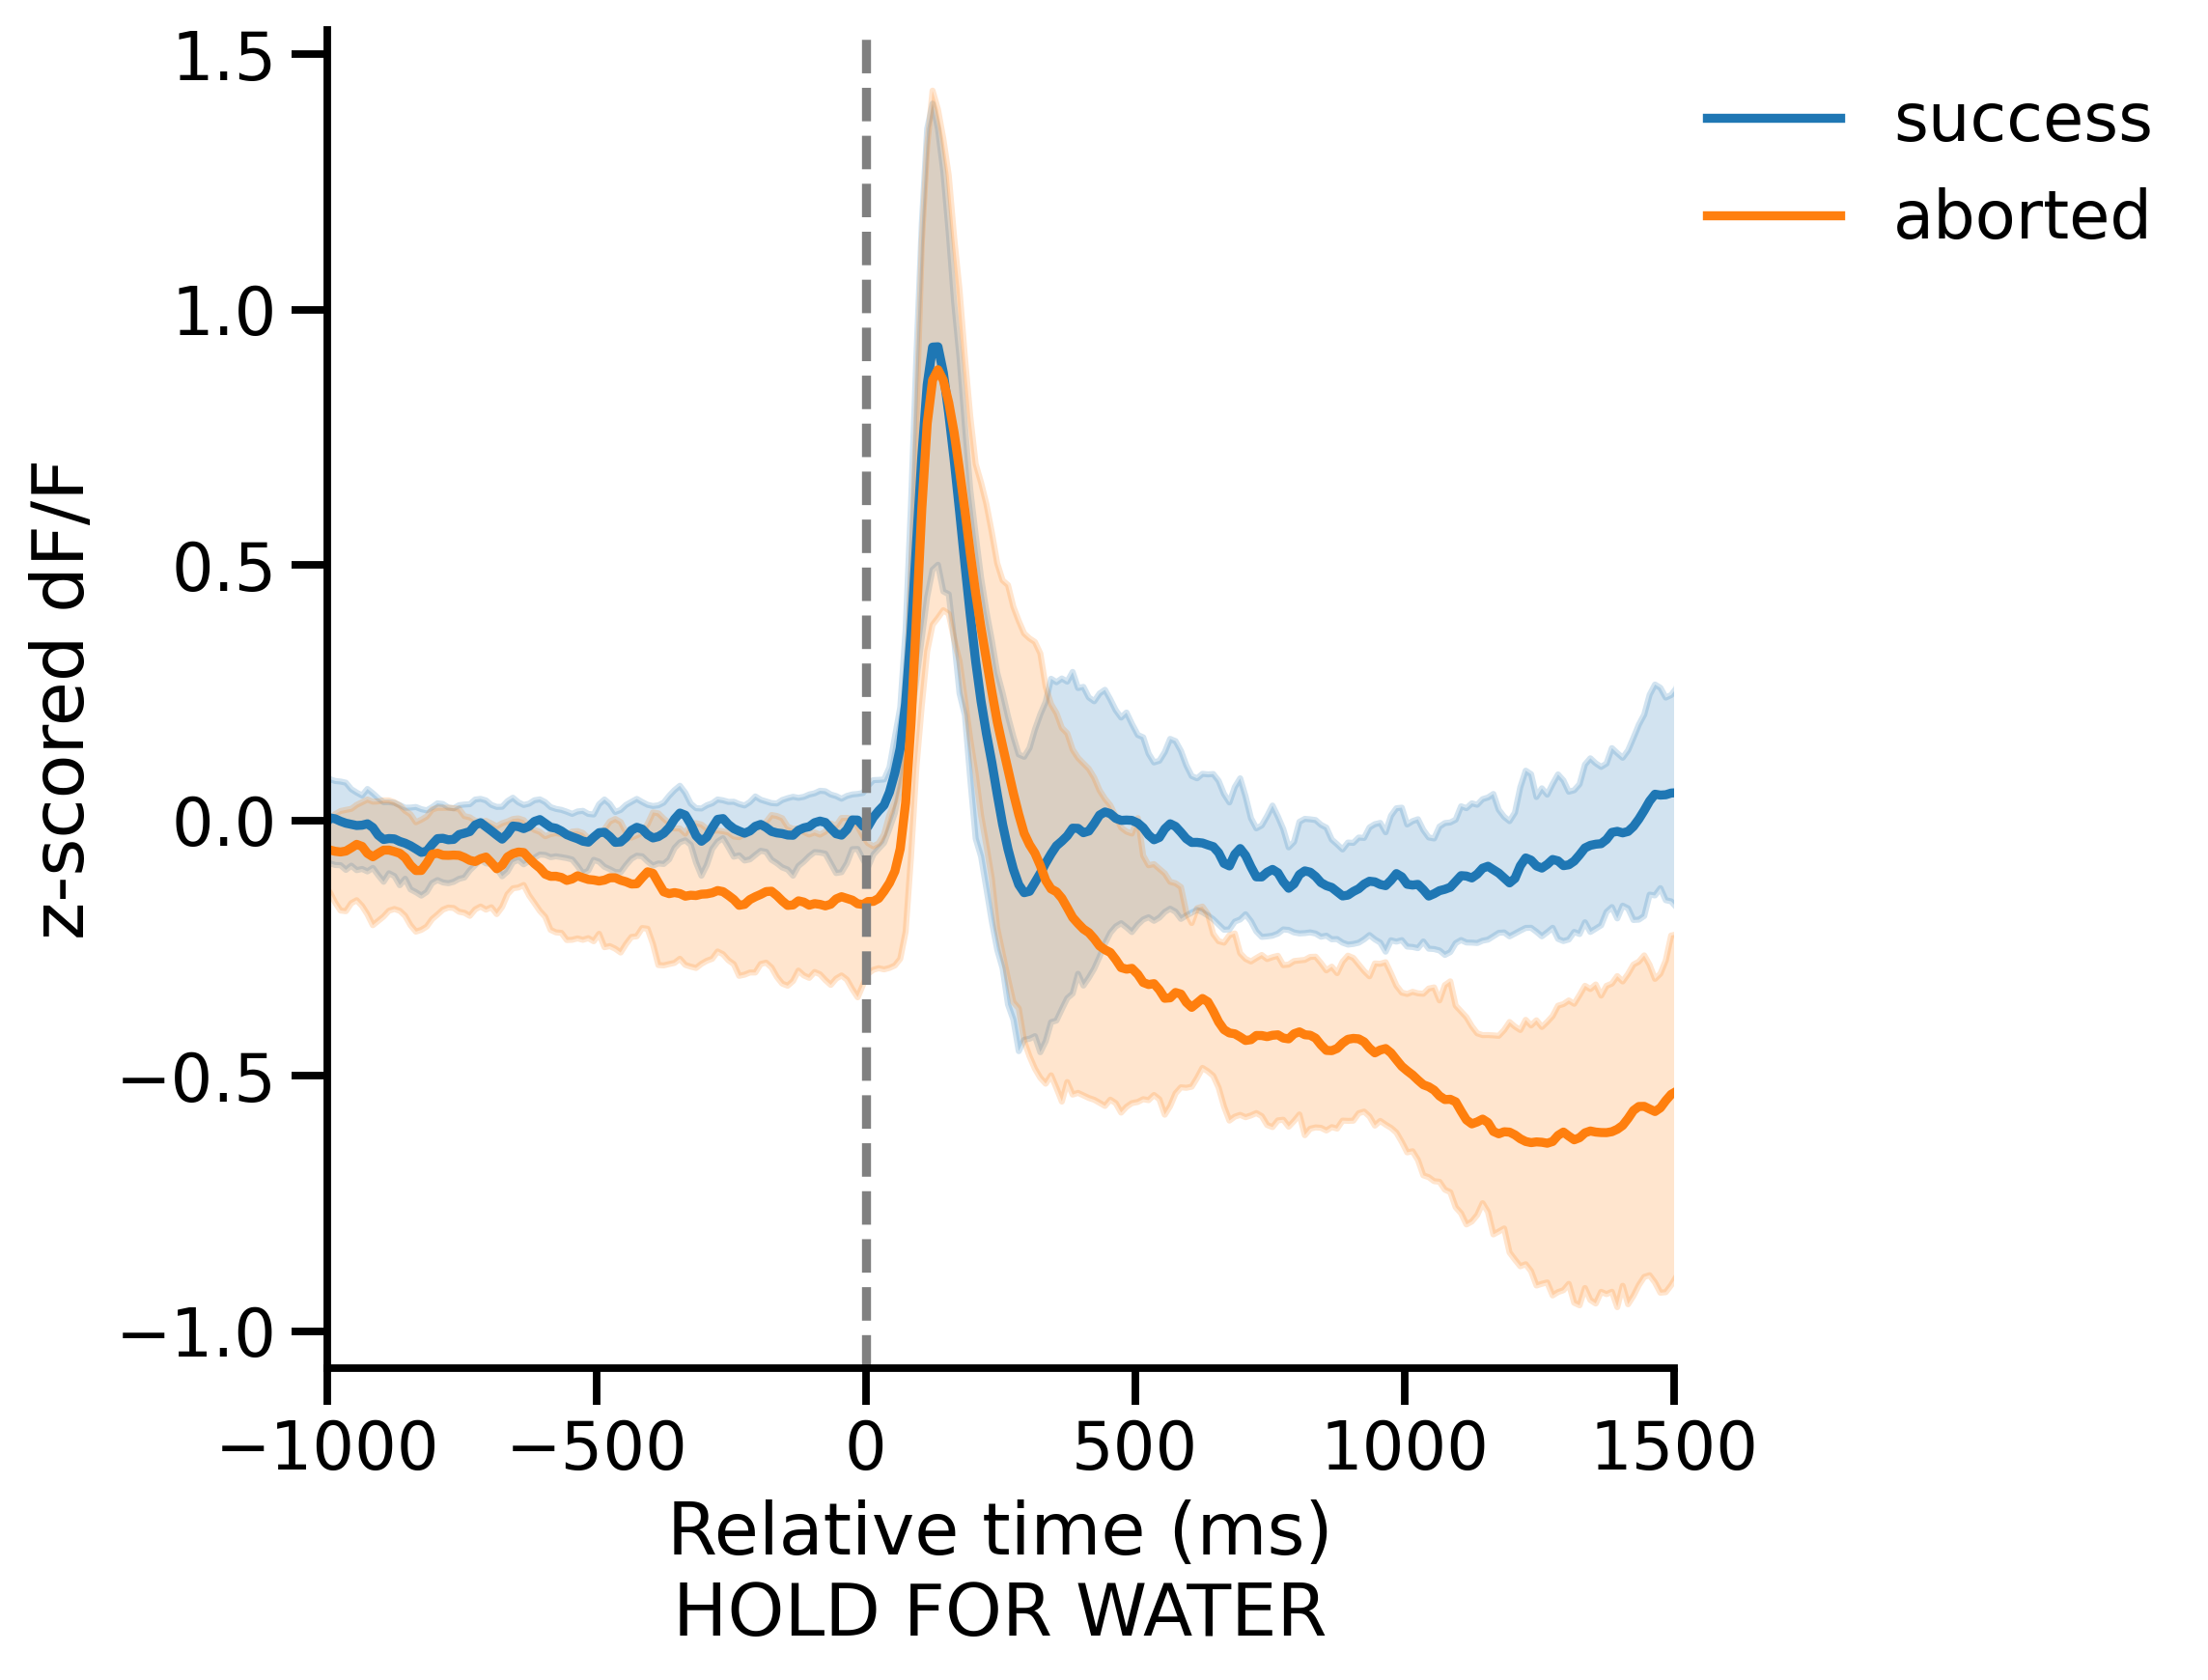

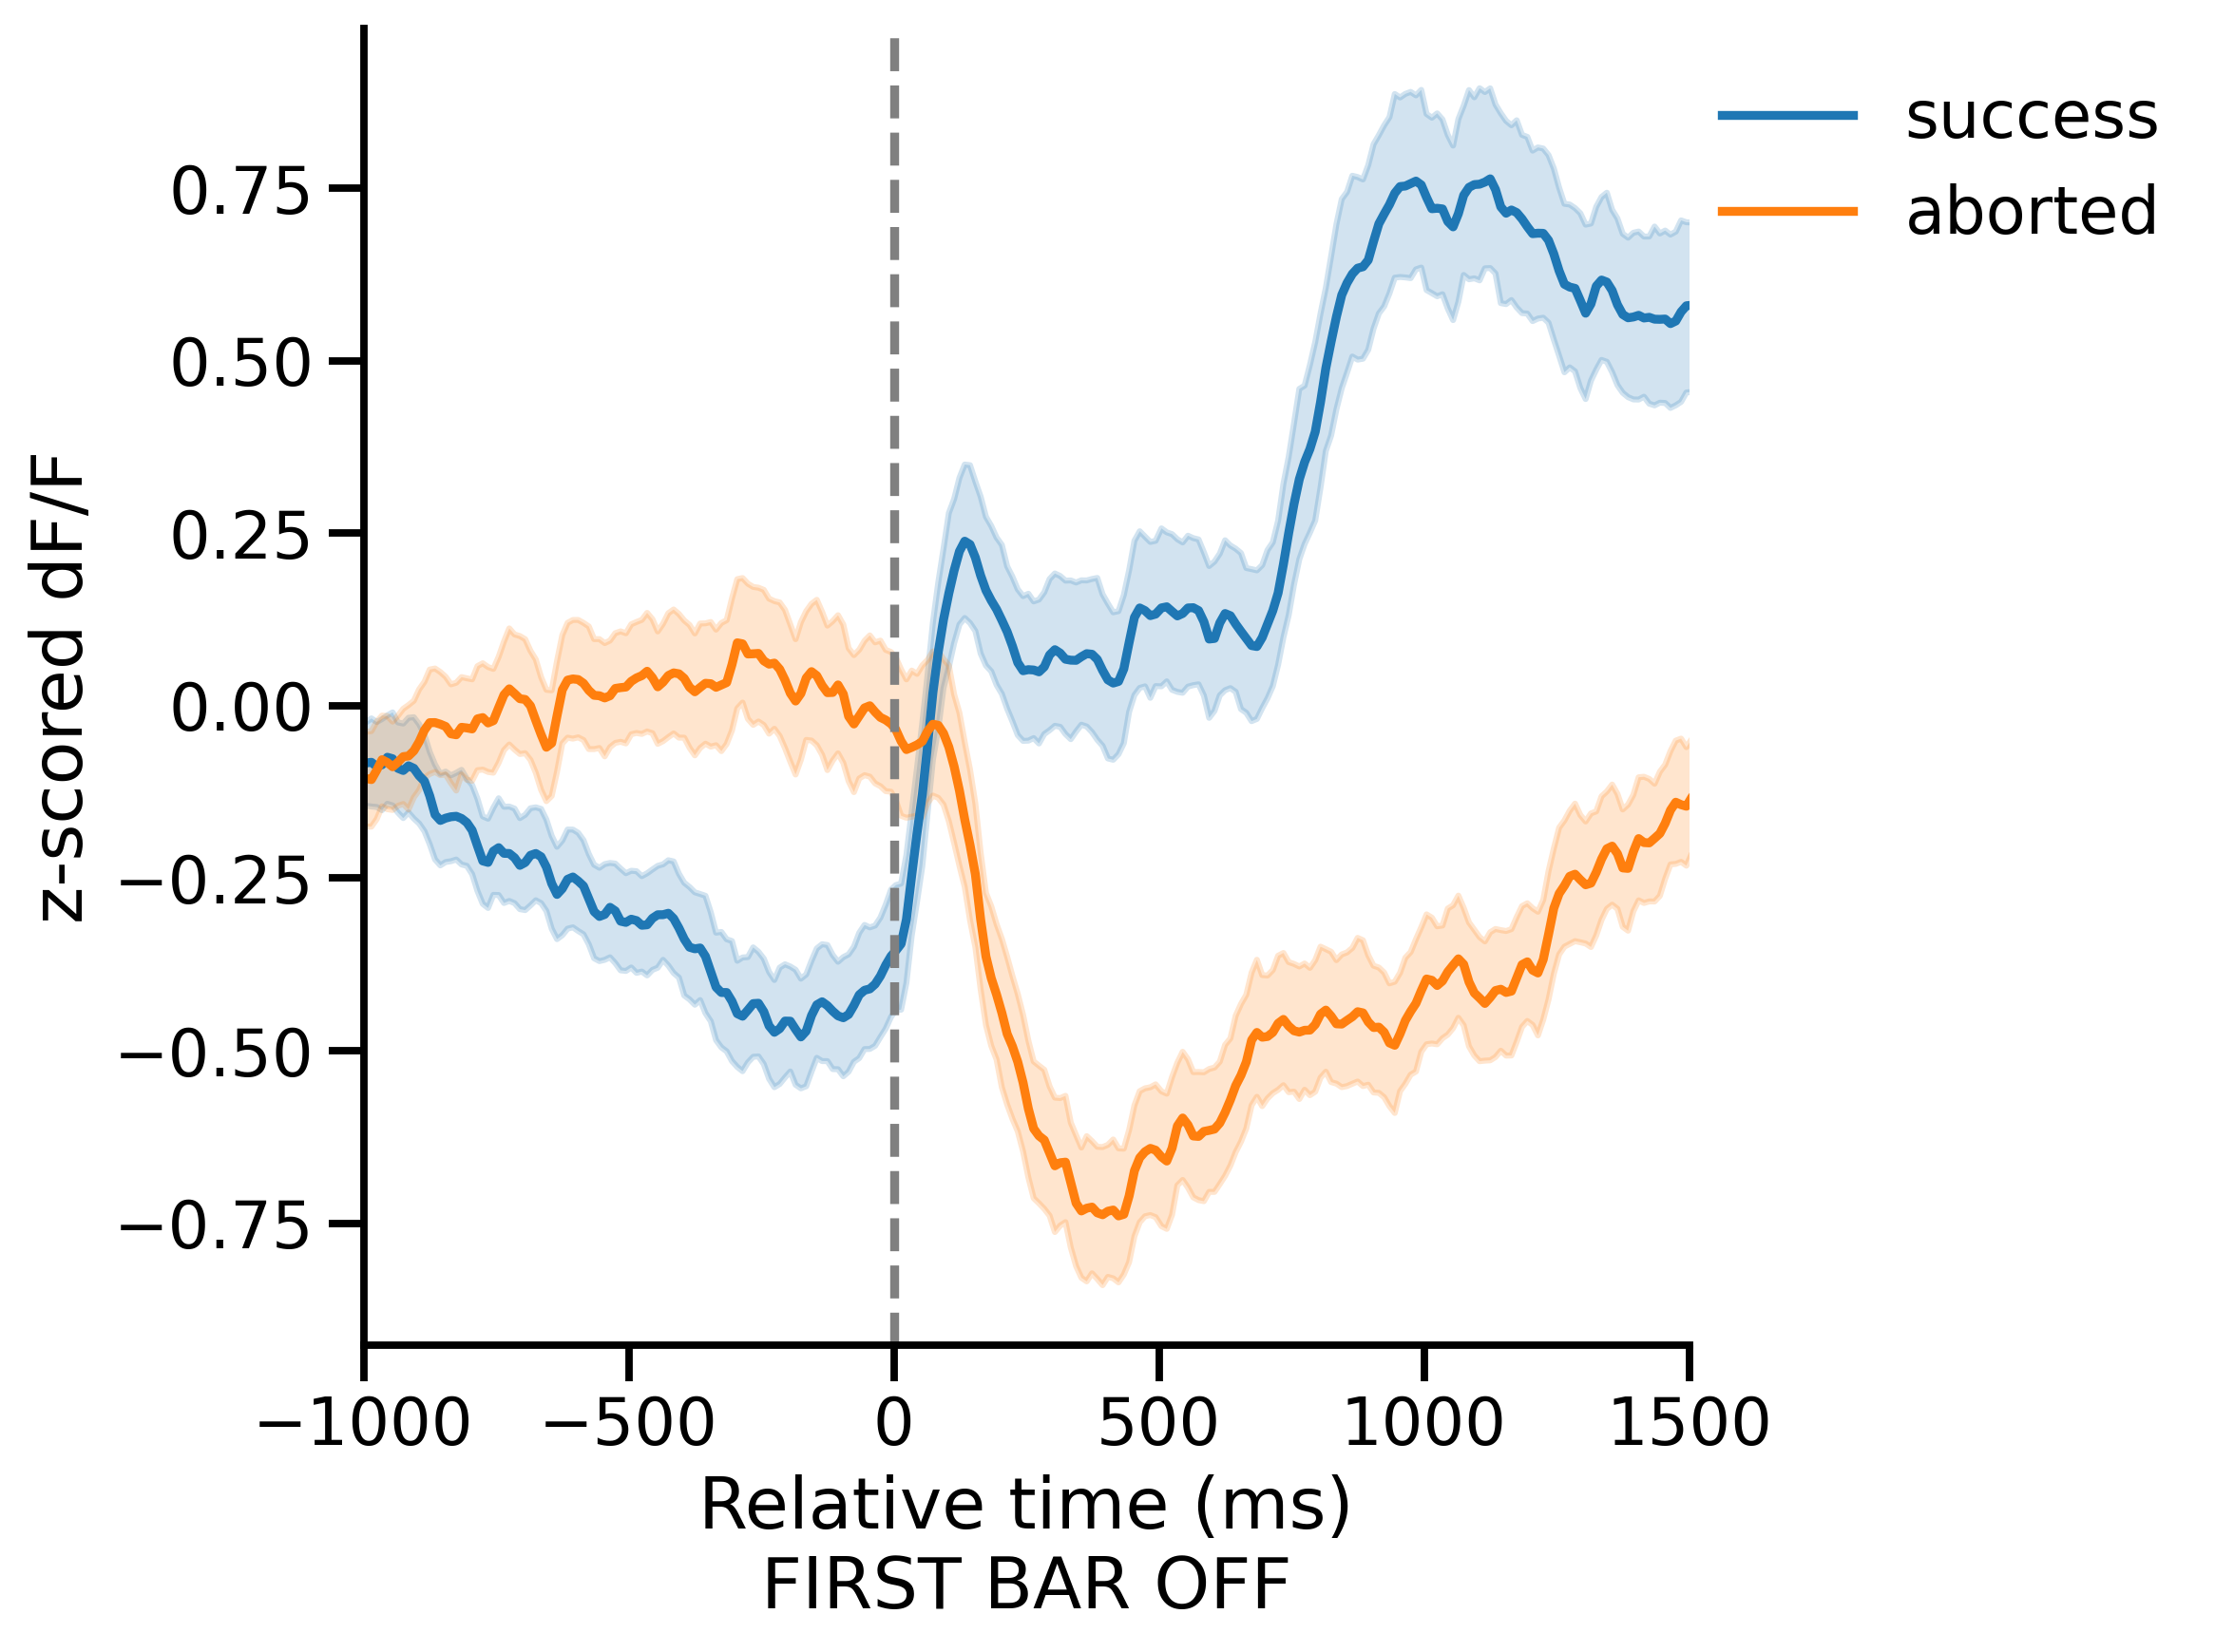

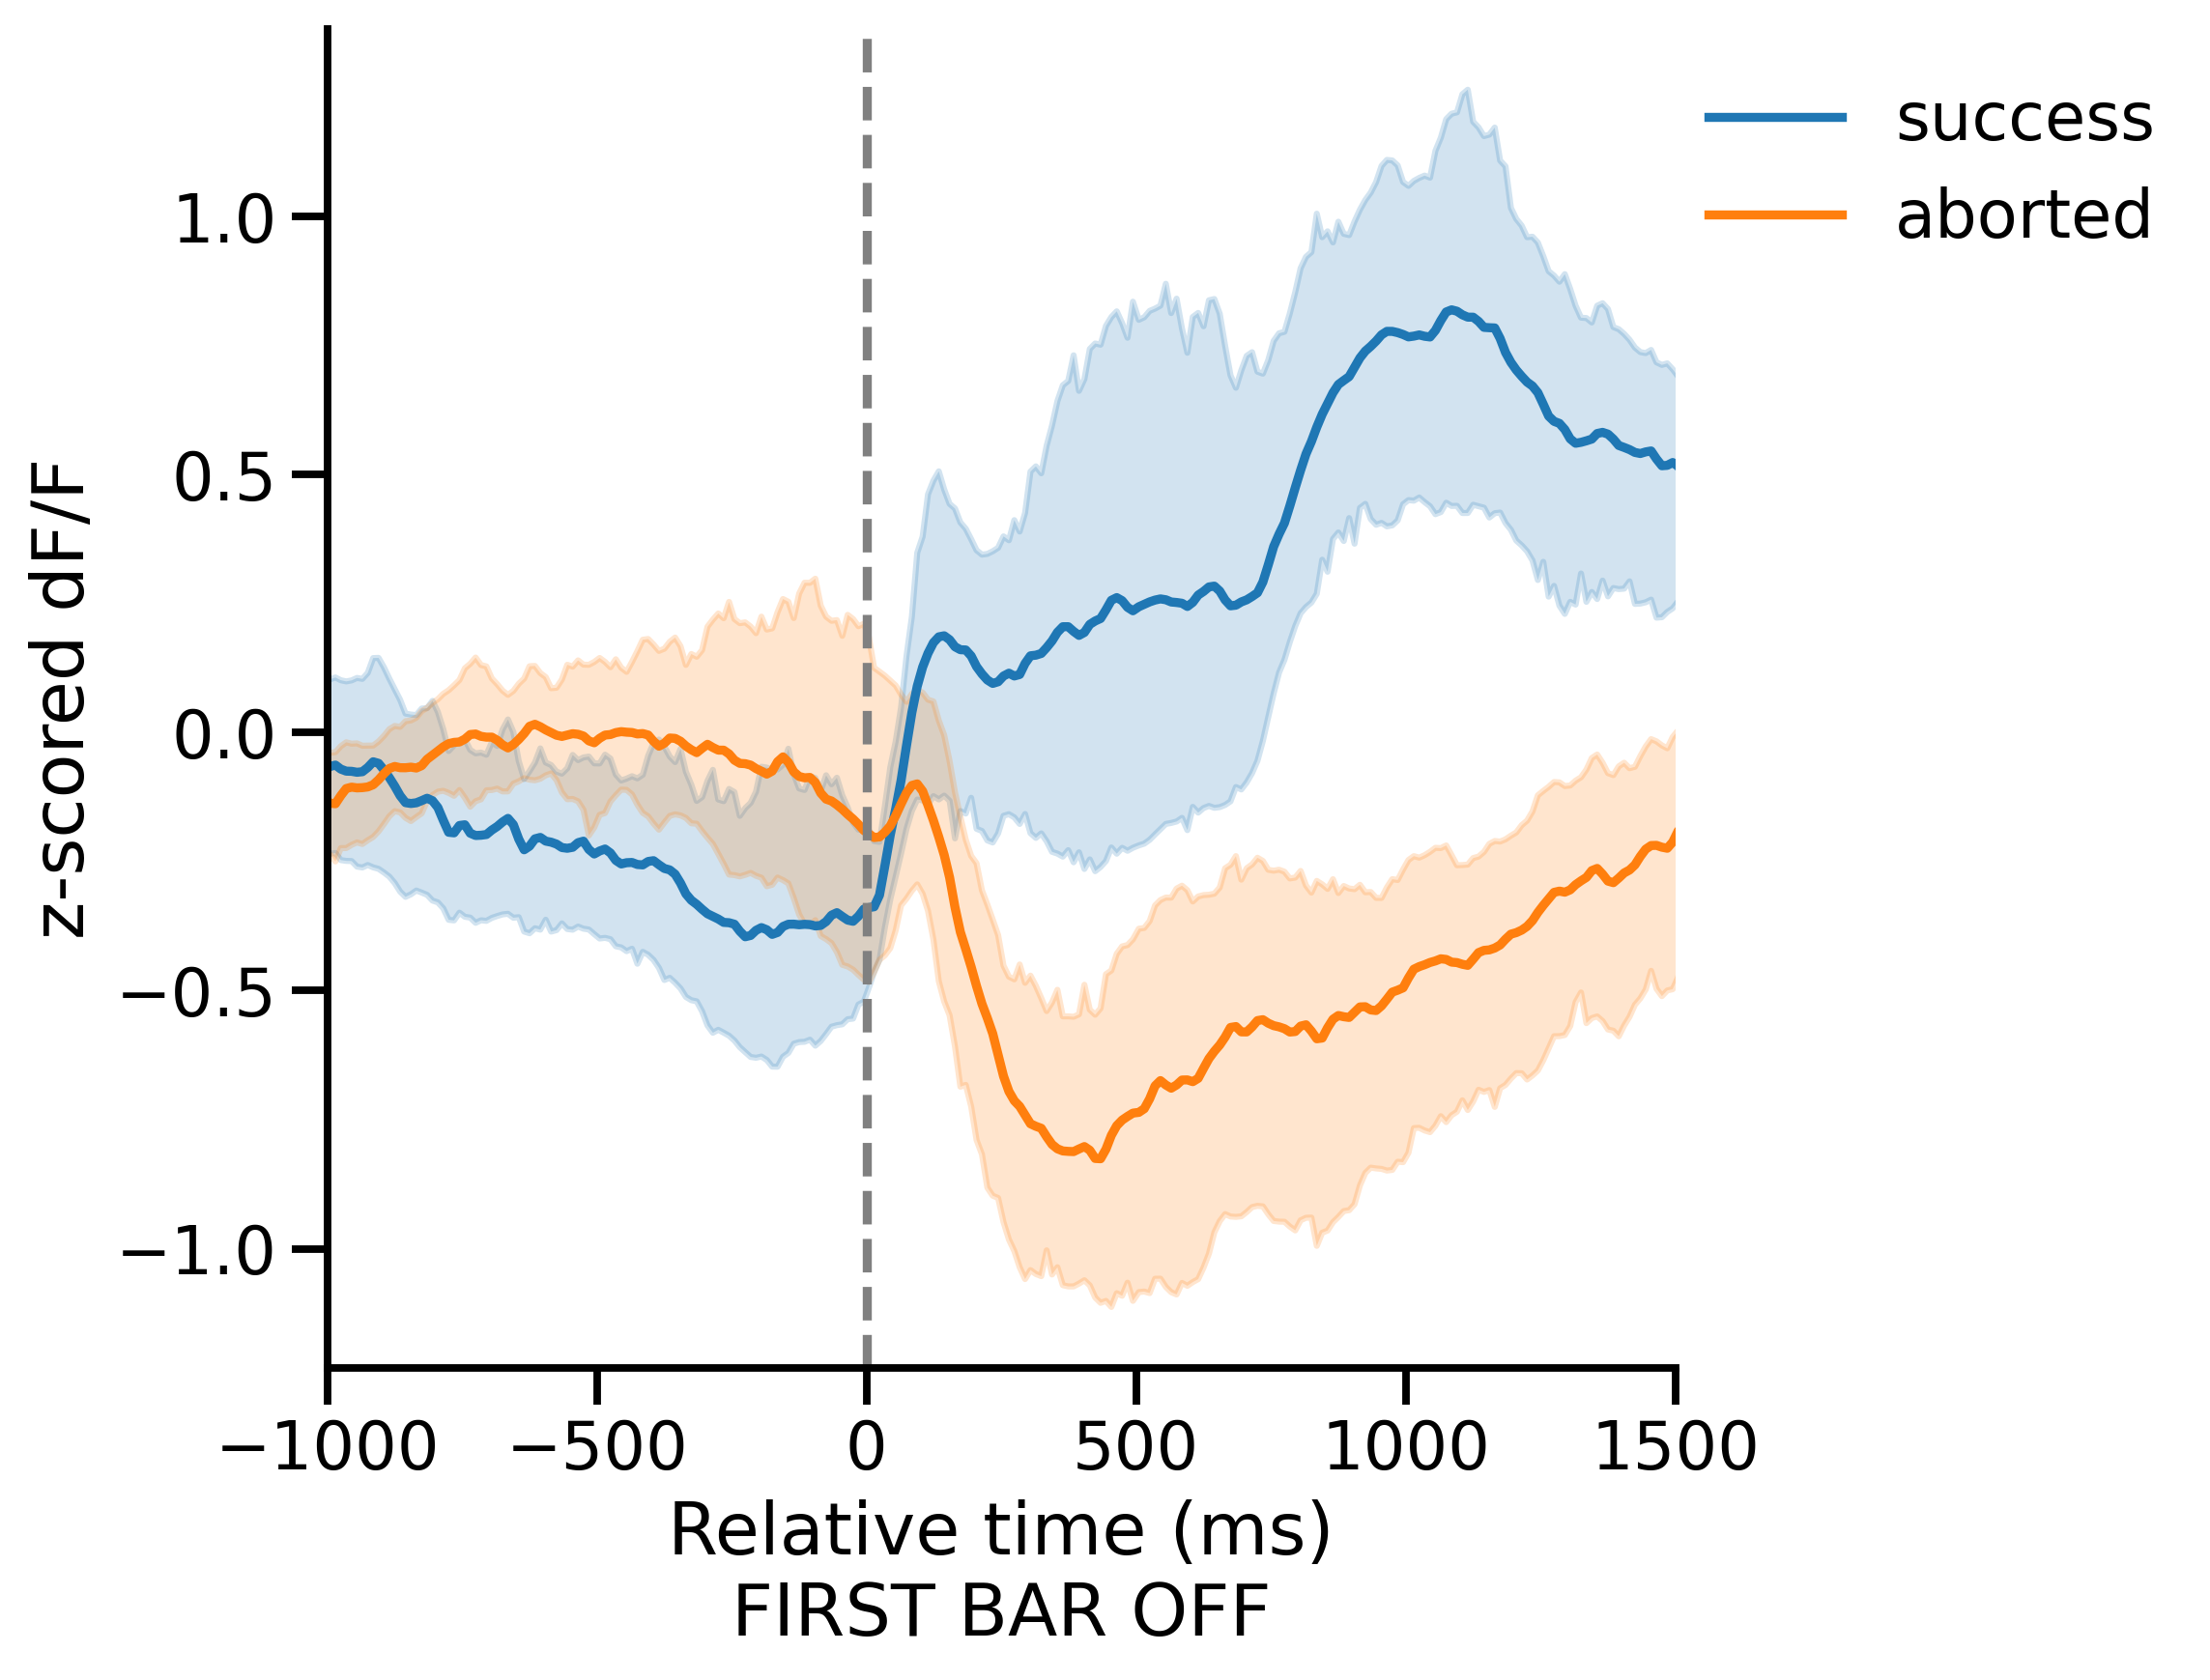

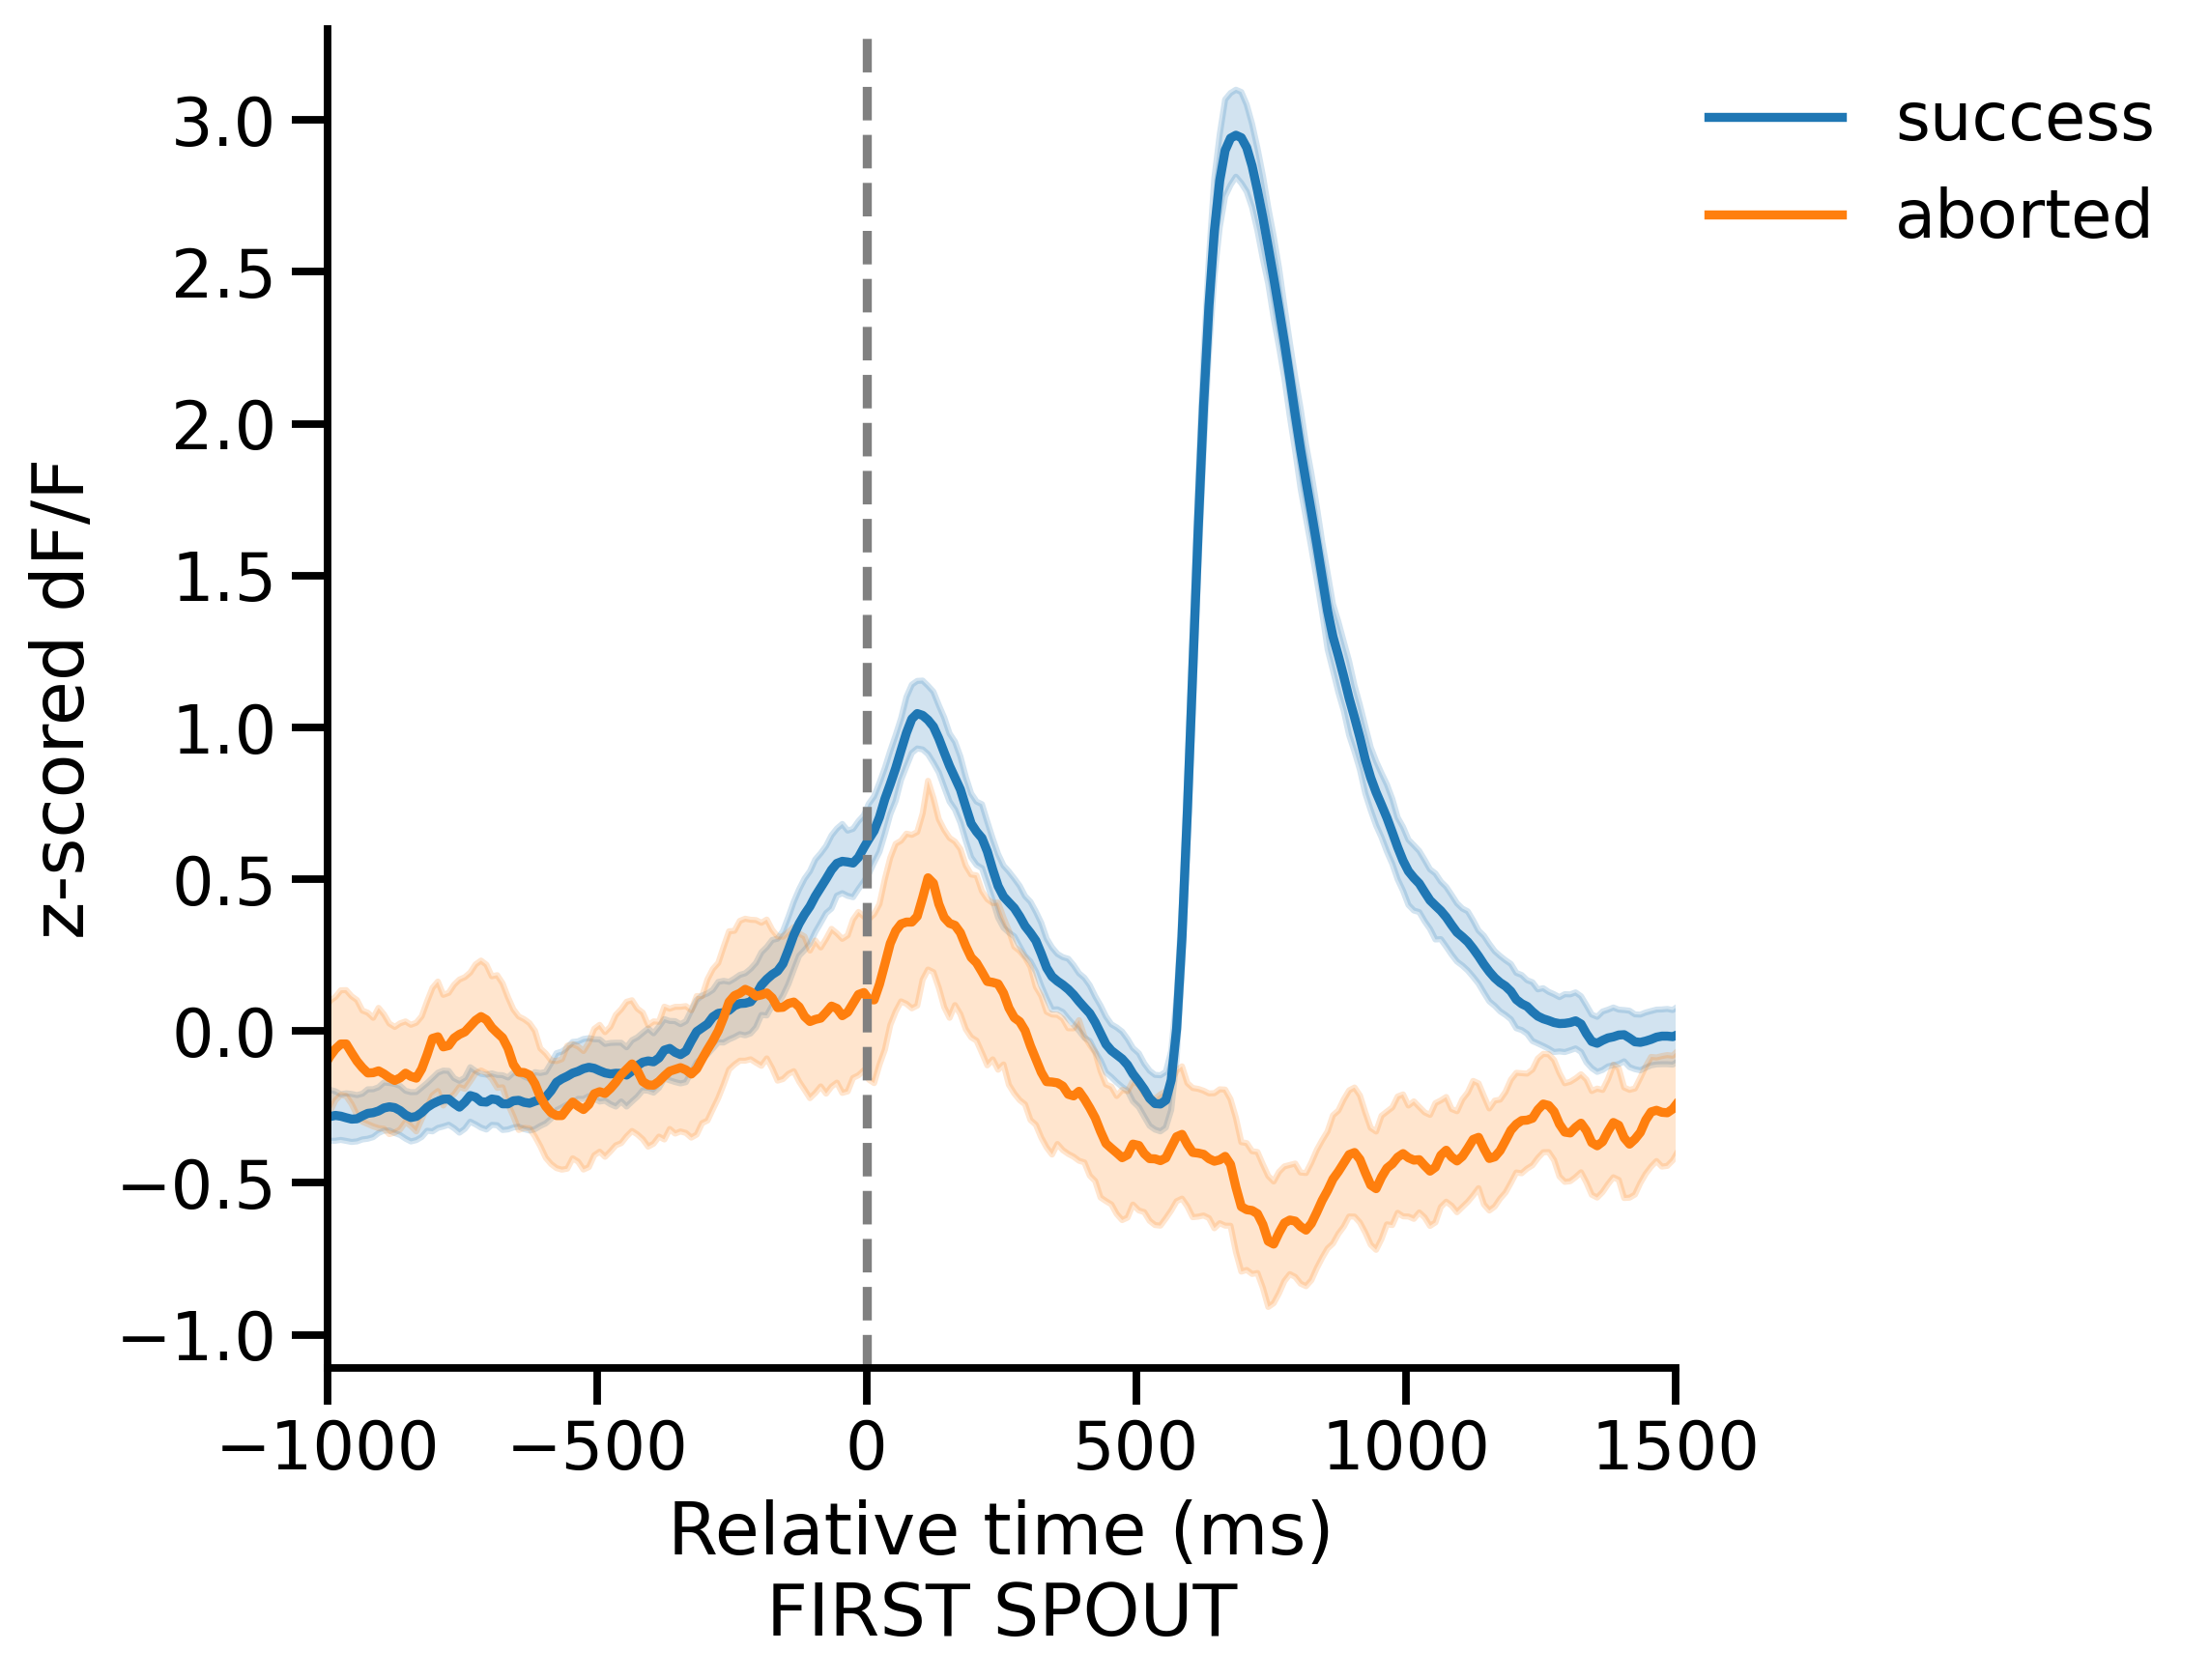

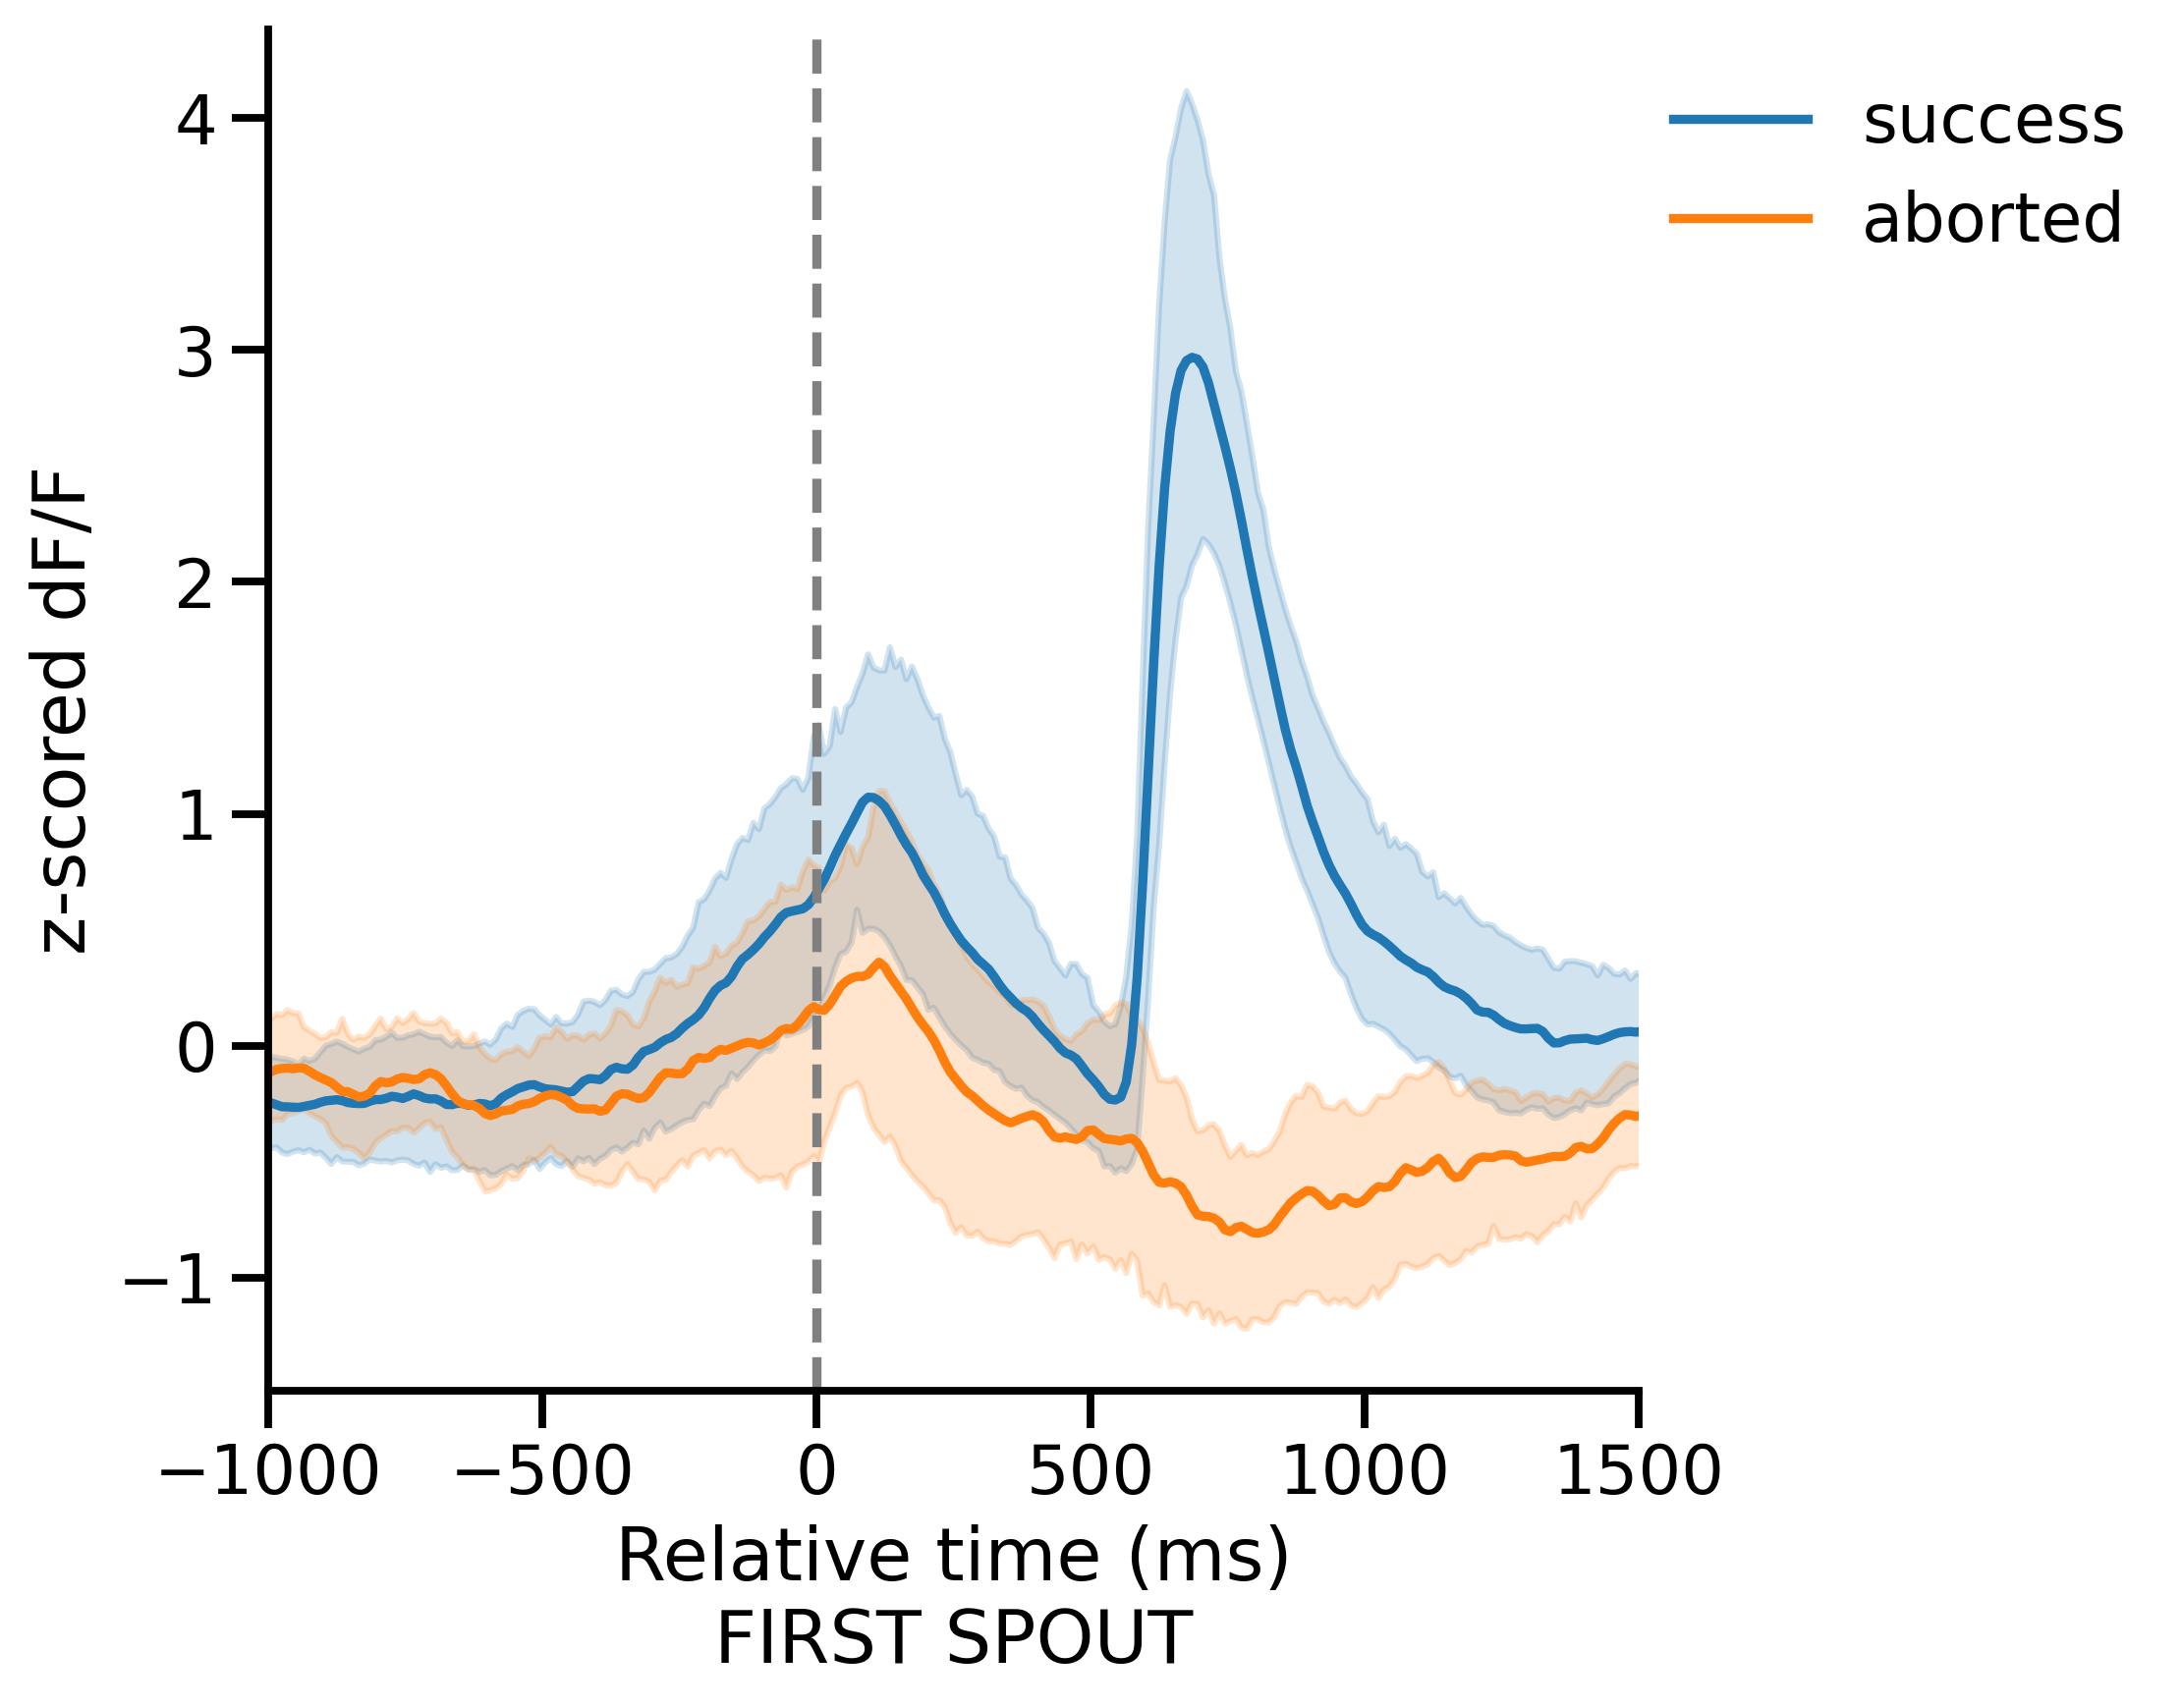

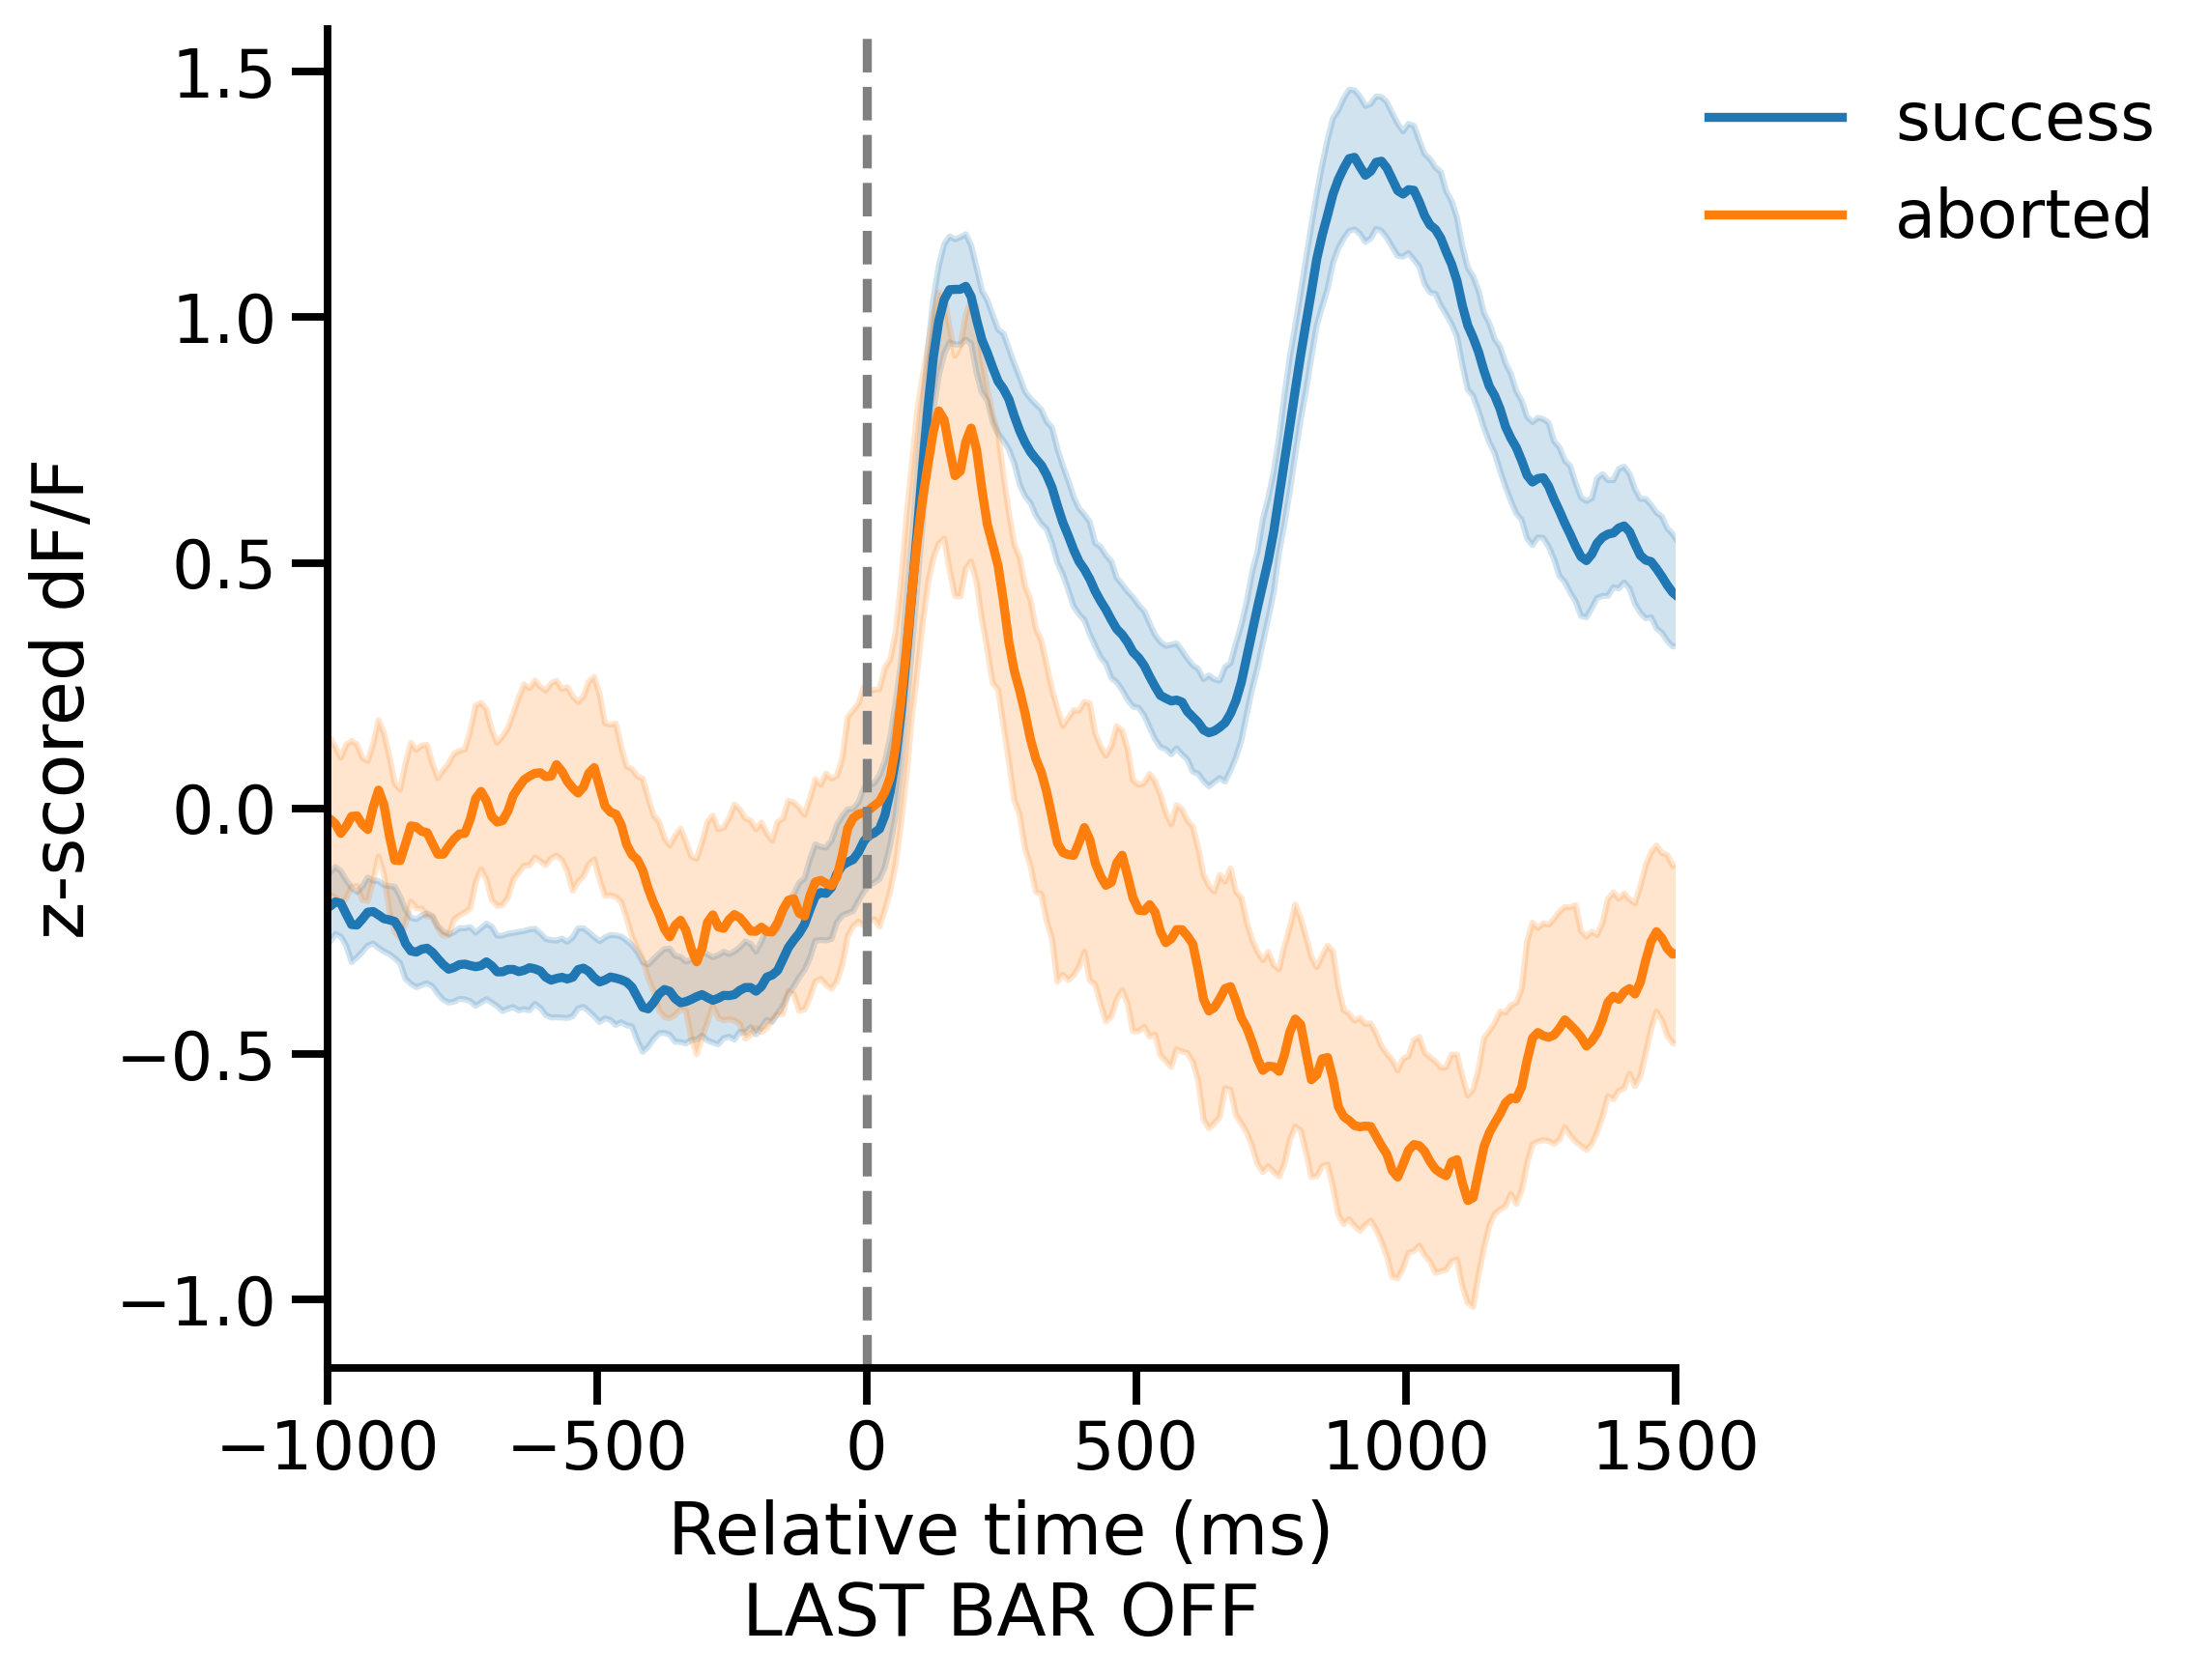

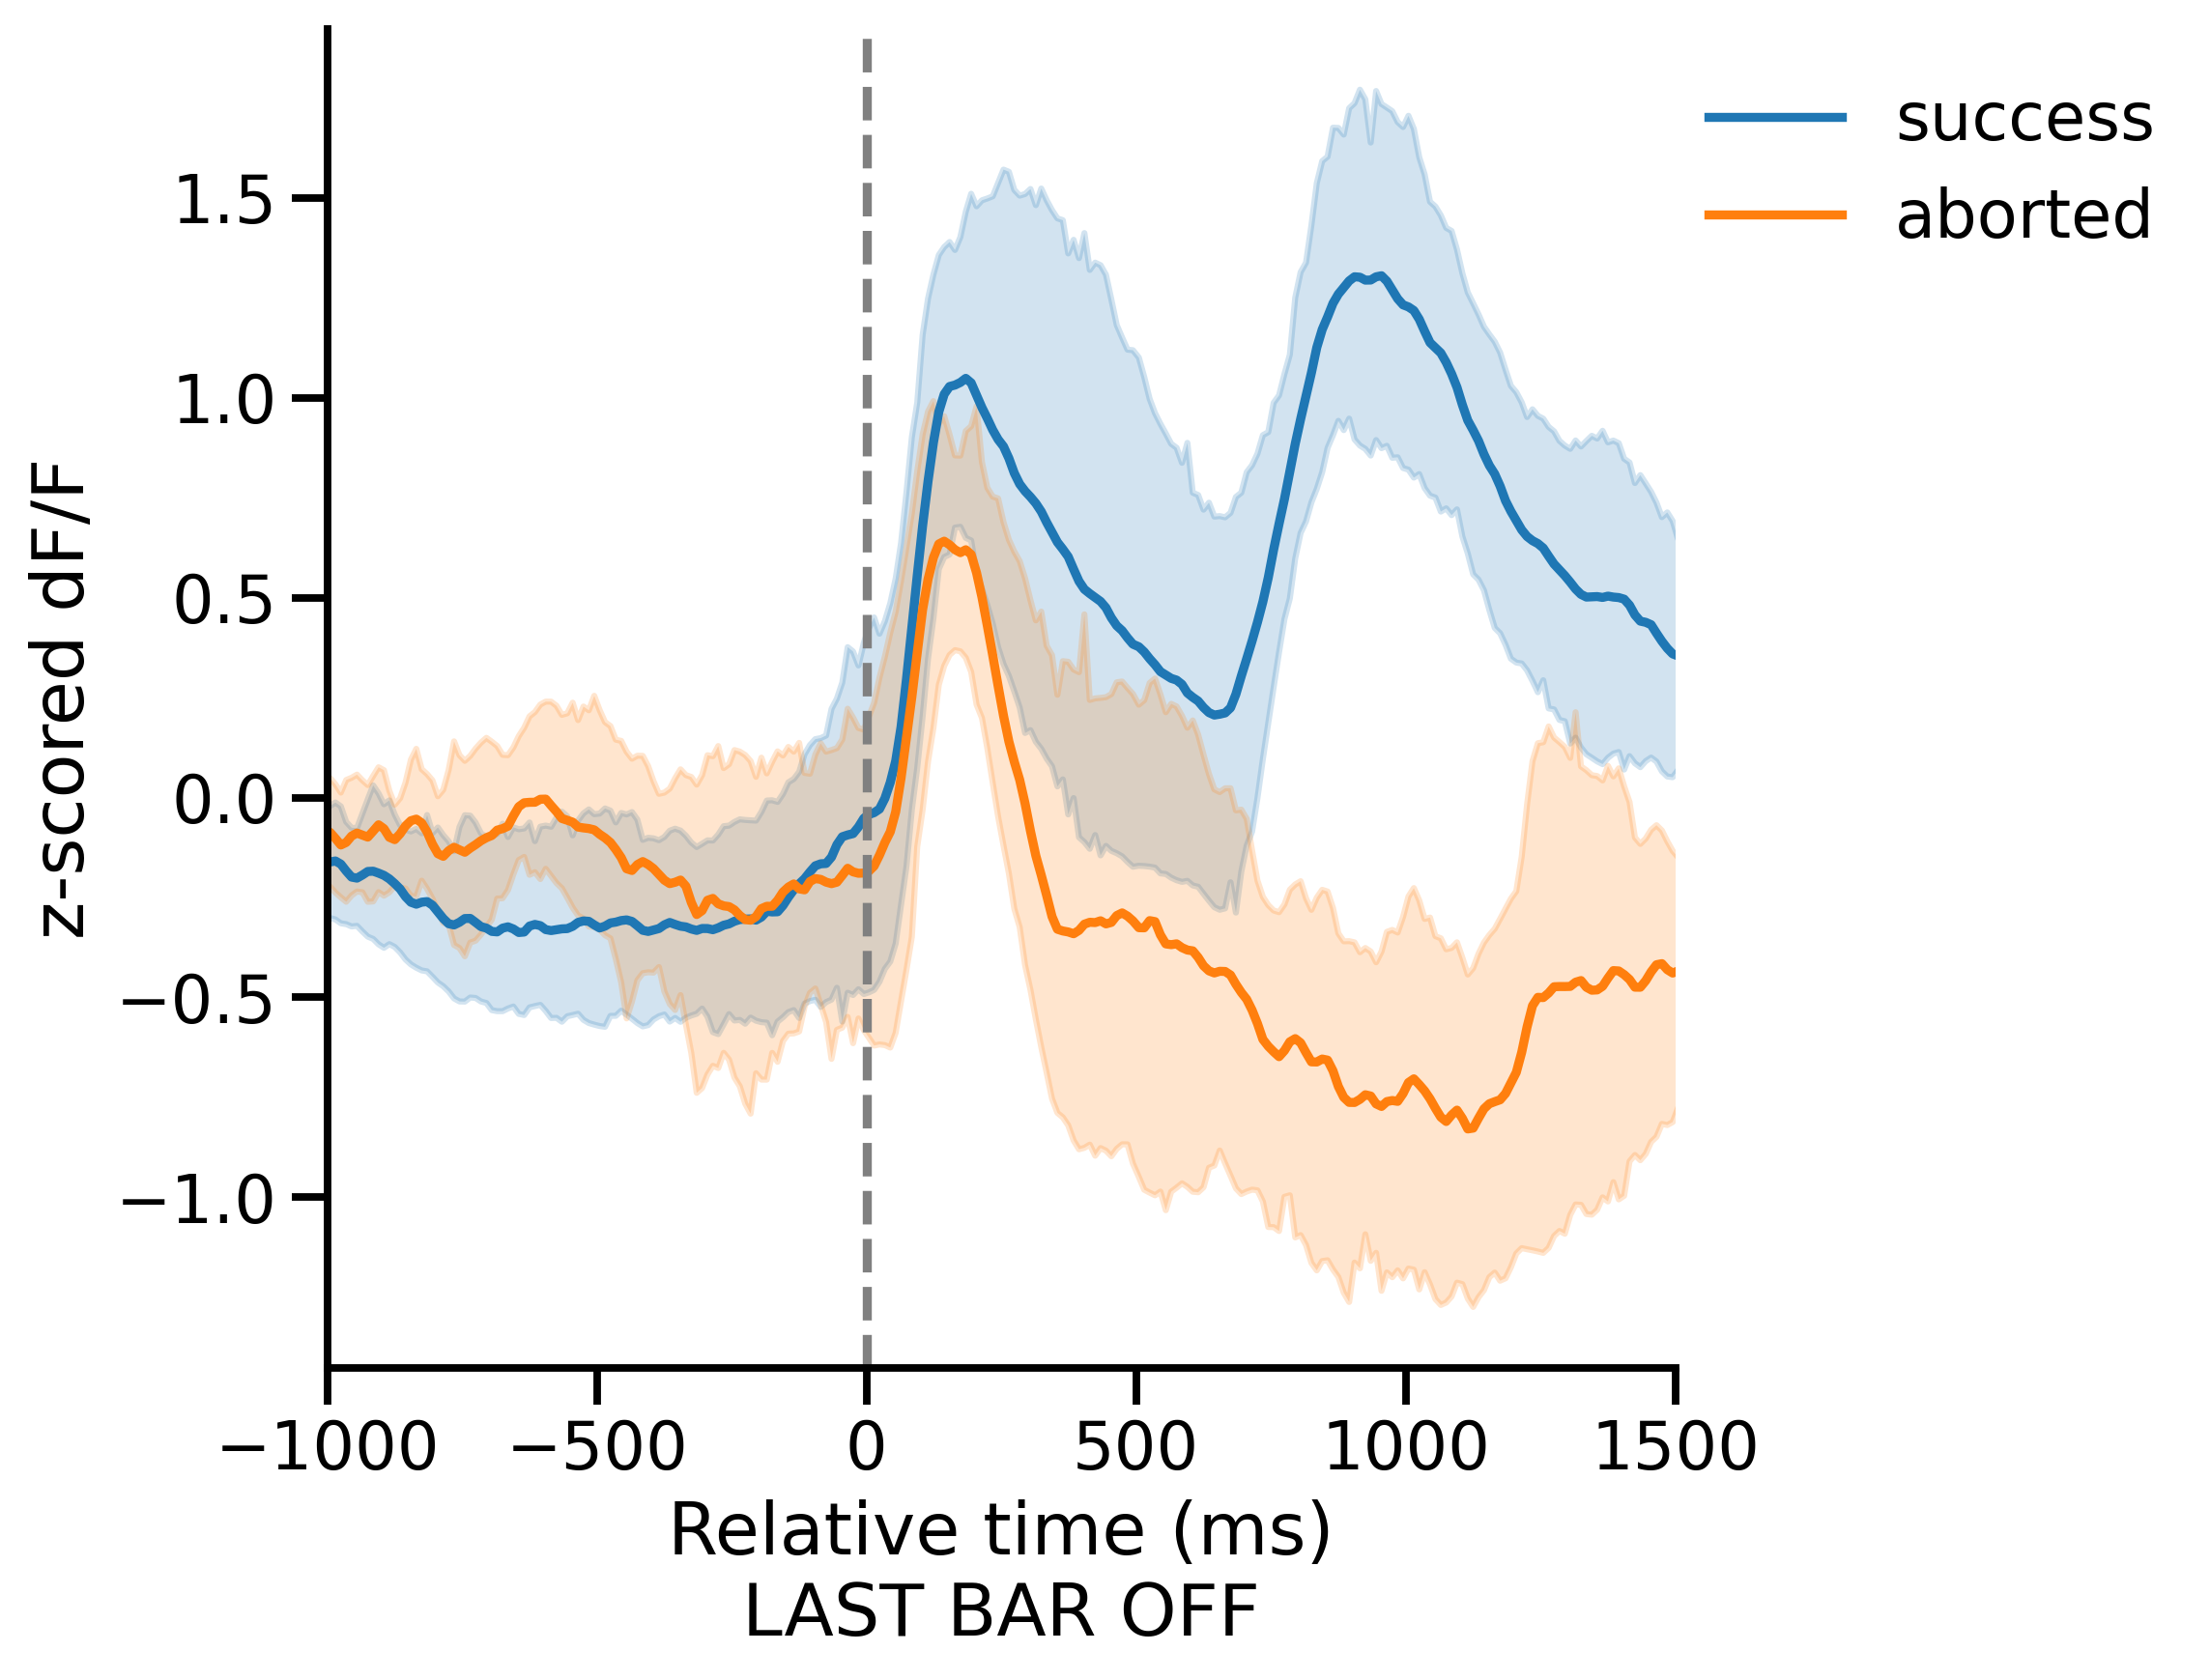

In [33]:
vars_to_plot = ['hold_for_water_zscored_df_over_f', 
                'first_bar_off_zscored_df_over_f',
                'first_spout_zscored_df_over_f',
                'last_bar_off_zscored_df_over_f']

average_mode = ['equal_subsample', 'mean_of_mean']

for v, mode in itertools.product(vars_to_plot, average_mode):
    fig, ax = plot_group_average(ds_combined, animal_id, v, average_method=mode)
    fig.savefig(f'figures/DA_group_average_{v}_{mode}.png', bbox_inches='tight')